# Week 5 - Deep learning with Transformers

Some preliminary set-up.

In [1]:
! pip install ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses --quiet

%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

sns.set()

# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding="utf8") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

Device: cuda

In [2]:
# prepare data for the later cells
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

# tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [01:02<00:00, 6351.05it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

# Language Modelling and Transformers

___
## Content

* I. Text to vectors
* II. Language models
* III. Attention mechanism
* IV. Transformers
* V. Applications of Transformer-based language models


___
## Introduction

Since its introduction (["Attention is All You Need", Wasrani et al. (2016)](https://arxiv.org/abs/1706.03762)), Transformers have overtaken the field of Machine Learning. Initially applied to translation tasks, Transformers pre-trained on vast amounts of unlabelled data such as BERT and GPT have been acquired as central components in most of the modern natural language processing (NLP) systems. Transformers power question answering (QA) models, machine translation services, search engines and chat bots. Independently of the language applications, the Transformer is also a versatile neural architecture and, therefore, has found success outside the field of NLP. Transformers are rapidly being adopted in image processing (["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Dosovitskiy et al. (2021)](https://arxiv.org/abs/2010.11929)), in reinforcement learning (["A Generalist Agent", Reed et al. (2022)](https://arxiv.org/abs/2205.06175)), video generation (["VideoGPT: Video Generation using VQ-VAE and Transformers", Yan et al. (2021)](https://arxiv.org/abs/2104.10157)), and more. In the following sections, we will first introduce the basics of NLP (tokenization, token embeddings, language modelling), introduce the attention mechanism. In the second part, we will study the Transformer architecture and apply it to NLP tasks.

___
## I. Text to vectors

In the previous labs, we have applied deep learning to processing images encoded as RGB pixels. We found that processing arrays of RGB pixels using convolutional neural network was effective. In NLP, other neural interfaces are required to enable plugging text into neural networks. Raw text cannot trivially be plugged-in neural networks. In this section we show how to convert text units or *tokens* into vectors and introduce the notion of text vector spaces.

### I.a. Tokenization

In [alphabetic languages](https://en.wikipedia.org/wiki/List_of_writing_systems), text can be decomposed into various types of units or *tokens*: characters, syllables, words or even sentences. Each tokenization system comes with vocabulary $\mathcal{V}$ that references all known symbols. 

The choice of tokenizer is a tradeoff between the size of the vocabulary and the number of tokens required to encode a sentence. For instance, character-level tokenizers result in a smaller vocabulary size (only 128 character when using ASCII encoding) than other tokenizers. Word-based tokenizers encode text using fewer tokens than the other tokenizers but require a much larger vocabulary, which still might miss words seen at test time. Sub-words tokenizers such as [WordPiece](https://arxiv.org/abs/2012.15524) and [byte-pair encoding (BPE)](https://arxiv.org/abs/1508.07909) are a tradeoff between character-level and word-level encoding. They have progressively taken over the field as they provide two main advantages: (i) good tradeoff between vocabulary size and encoding length, (ii) open-ended vocabulary. 

Below we tokenize one sentence using word-level, character-level and sub-word-level tokenizers. In each case, the output corresponds to a sequence of indexes corresponding to the position of the given token in the vocabulary.

In [3]:
# Example sentence with rare English words and non-english words
sentence = "It is jubilating to see how élégant my horse has became"
rich.print(f"Input sentence: [bold blue]`{sentence}`")

# Define multiple tokenizers
tokenizer_ids = {
    "Word-level": glove_tokenizer,
    "WordPiece": "bert-base-cased",
    "BPE": "distilgpt2",
    "Character-level":  "google/byt5-small",
    }

# print("he")

# iterate through the tokenizers and decode the input sentences
for tokenizer_name, tokenizer in tokenizer_ids.items():
    # intialize the tokenizer (either)
    if isinstance(tokenizer, str):
        # init a `transformers.PreTrainedTokenizerFast`
        tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer)
        vocab_size = tokenizer.vocab_size
        # print("he")
    else:
        # use the provided `tokenizers.Tokenizer``
        vocab_size = tokenizer.get_vocab_size()

    # Tokenize
    token_ids = tokenizer.encode(sentence, add_special_tokens=False)
    if isinstance(token_ids, tokenizers.Encoding):
        token_ids = token_ids.ids

    # Report
    rich.print(f"[red]{tokenizer_name}[/red]: sentence converted into {len(token_ids)} tokens (vocabulary: {vocab_size} tokens)")
    rich.print(f"Tokens:\n{[tokenizer.decode([t]) for t in token_ids]}")
    rich.print(f"Token ids:\n{[t for t in token_ids]}")

Input sentence: `It is jubilating to see how élégant my horse has became`

Word-level: sentence converted into 11 tokens (vocabulary: 400004 tokens)

Tokens:
['it', 'is', '<|unknown|>', 'to', 'see', 'how', '<|unknown|>', 'my', 'horse', 'has', 'became']

Token ids:
[23, 17, 1, 7, 256, 200, 1, 195, 2870, 34, 305]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


WordPiece: sentence converted into 15 tokens (vocabulary: 28996 tokens)

Tokens:
['It', 'is', 'j', '##ubi', '##lating', 'to', 'see', 'how', 'é', '##lé', '##gant', 'my', 'horse', 'has', 'became']

Token ids:
[1135, 1110, 179, 25422, 18156, 1106, 1267, 1293, 255, 18076, 24581, 1139, 3241, 1144, 1245]

BPE: sentence converted into 17 tokens (vocabulary: 50257 tokens)

Tokens:
['It', ' is', ' j', 'ub', 'il', 'ating', ' to', ' see', ' how', ' é', 'lé', 'g', 'ant', ' my', ' horse', ' has', ' 
became']

Token ids:
[1026, 318, 474, 549, 346, 803, 284, 766, 703, 38251, 45031, 70, 415, 616, 8223, 468, 2627]

Character-level: sentence converted into 57 tokens (vocabulary: 256 tokens)

Tokens:
['I', 't', ' ', 'i', 's', ' ', 'j', 'u', 'b', 'i', 'l', 'a', 't', 'i', 'n', 'g', ' ', 't', 'o', ' ', 's', 'e', 'e',
' ', 'h', 'o', 'w', ' ', '', '', 'l', '', '', 'g', 'a', 'n', 't', ' ', 'm', 'y', ' ', 'h', 'o', 'r', 's', 'e', ' ',
'h', 'a', 's', ' ', 'b', 'e', 'c', 'a', 'm', 'e']

Token ids:
[76, 119, 35, 108, 118, 35, 109, 120, 101, 108, 111, 100, 119, 108, 113, 106, 35, 119, 114, 35, 118, 104, 104, 35, 
107, 114, 122, 35, 198, 172, 111, 198, 172, 106, 100, 113, 119, 35, 112, 124, 35, 107, 114, 117, 118, 104, 35, 107,
100, 118, 35, 101, 104, 102, 100, 112, 104]

### I.b Embeddings

A tokenizer transforms fragments of text into list of integers that maps a vocabulary. We assign one vector of dimension $d$ to each item in the vocabulary of size $N_\mathcal{V}$, this results in a matrix $E$ of dimension ${N_\mathcal{V} \times d}$. Converting a fragment of text into a sequence of vector representations can be done by tokenizing the text, and then looking up the embedding vector for each token, which is equivalent to *one-hot encoding* the tokens and performing a matrix multiplication using $E$. Given $\mathbf{t}_1, \ldots, \mathbf{t}_L$ the sequence of one-hot encoded tokens, this is equivalent to
$$
\mathbf{w}_i = E  \mathbf{t}_i ,
$$
In the code below, we encode the sentence `Hellow world!` using a BPE tokenizer and a set of embedding of dimension `hdim`.

In [4]:
hdim = 5 # embedding dimension
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased") # tokenizer
sentence = "Hello World!" # input text
embeddings = torch.randn((tokenizer.vocab_size, hdim)) # embedding matrix
rich.print(f"Embeddings (shape): {embeddings.shape}")
token_ids = tokenizer.encode(sentence, add_special_tokens=False, return_tensors="pt")[0]
rich.print(f"Tokens ids (shape): {token_ids.shape}")
vectors =  torch.nn.functional.one_hot(token_ids, tokenizer.vocab_size).float() @ embeddings # equivalent to a `nn.Linear` layer
rich.print(f"Vectors (shape): {vectors.shape}")
rich.print(f"List of tokens and their corresponding vectors:")
for t,v in zip(token_ids, vectors):
    token_info = f"[blue]{tokenizer.decode(t):5}[/blue] (token id: {t:4})"
    rich.print(f" * {token_info} -> {v}")

# NB: in practice, we use the simpler interface `torch.nn.Embedding``
# embeddings = torch.nn.Embedding(tokenizer.vocab_size, hdim)
# vectors = embeddings(token_ids)

Embeddings (shape): torch.Size([30522, 5])

Tokens ids (shape): torch.Size([3])

Vectors (shape): torch.Size([3, 5])

List of tokens and their corresponding vectors:

* hello (token id: 7592) -> tensor([-0.8185, -1.7294,  0.6260,  1.2693, -0.8500])

* world (token id: 2088) -> tensor([ 0.1143,  0.8675,  0.3923, -0.3526, -1.9800])

* !     (token id:  999) -> tensor([-0.8444,  1.2893, -2.4700, -1.9743, -0.3324])

### I.c Word vectors

<img src="images/word2vec-intuition.png" alt="Word2vec: translations in the vector spaces correspond to linguistic concepts (gender, verb tense, association between concepts)" width="800px"/>


Word2vec (["Efficient Estimation of Word Representations in Vector Space", Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781)) converts words into vector representations, which are learned using the Skip-Gram algorithm. Intuitively, The algorithm is based on the idea that words that appear together are related to each other.

The word vector space allows to use the inner product to compare words, and arithmetic operations to manipulate word representations. For instance, in a well-defined word vector space, the concept "king" can be translated into "queen" by applying a linear transformation and the vector `vec("captial") - vec("country")` was found to correspond to the relative concept `"capital city of a country"` (see above illustration (*Image credits: https://www.tensorflow.org/tutorials/word2vec*)).


**Experiment** In the first cells, we have downloaded the [GloVe word vectors](ttps://github.com/stanfordnlp/GloVe) from ["GloVe: Global Vectors for Word Representation", Jeffrey Pennington et al. (2014)](https://arxiv.org/abs/1902.11004). GloVe are trained using a Skip-Gram objective on a large collection of documents. 

In [5]:
def word2vec(
        word: str,
        vocabulary:List[str],
        vectors: torch.Tensor
    ) -> Optional[torch.Tensor]:
    """Convert a word into a vector"""
    word = word.lower()
    if word in vocabulary:
        word_idx = vocabulary.index(word)
        return vectors[word_idx]
    else:
        return None

def vec2words(
        vec: torch.Tensor,
        k=5,
        *,
        vocabulary:List[str],
        vectors: torch.Tensor,
        exclude_vecs: List[torch.Tensor] = None,
    ) -> Tuple[List[str], torch.Tensor]:
    """Retrieve the nearest word neighbours for an input vector"""

    # compute the similarity between `vec`and all the vectors in `glove_vectors`
    similarity = vectors @ vec

    # potentially filter out some vocabulary entries
    if exclude_vecs is not None and len(exclude_vecs):
        mask = None
        for e in exclude_vecs:
            mask_ = (vectors == e[None, :]).all(dim=1)
            if mask is None:
                mask = mask_
            else:
                mask |= mask_
        similarity.masked_fill_(mask=mask, value=-math.inf)

    # return the ids of the nearesrt neighbours given the similarity
    nearest_neighbour_ids = torch.argsort(-similarity)[:k]

    # retrieve the corresponding words in the `vocabulary``
    return [vocabulary[idx] for idx in nearest_neighbour_ids], similarity[nearest_neighbour_ids]

# register the vocab and vectors args
glove_args = {'vocabulary':glove_vocabulary, 'vectors':glove_vectors}

# Nearest neighbours
rich.print("[red]Nearest neighbour search:")
for word in ["king", "queen", "dog", "France"]:
    rich.print(f'Nearest neighbours of the word "{word}":')
    word_vec = word2vec(word, **glove_args)
    words, similarities = vec2words(word_vec, k=5, **glove_args, exclude_vecs=[word_vec])
    rich.print(f"Words: {words}")
    rich.print(f"Similarities: {similarities}")

# Word analogies
rich.print("\n[red]Vector arithmetic:")
cases = [
    [("+", "king"), ("-", "man"), ("+", "woman")],
    [("+", "denmark"), ("-", "france"), ("+", "paris")],
    [("+", "pakistan"), ("-", "belgium"), ("+", "brussels")],
]
for operations in cases:
    # current location in the vector space
    location = 0
    rich.print(f"Vector Translation: [blue]0 {' '.join(f'{d} {v}' for d,v in operations)} = ")
    for sign, word in operations:
        # retrieve the `vec(word)``
        vec = word2vec(word, **glove_args)
        if vec is None:
            raise ValueError(f"Unknown word `{word}`")

        # parse the direction (+/-)
        direction = {"+": 1, "-": -1}[sign]

        # apply the vector transform to the current location
        location  +=  direction * vec

    # return the nearest neighbours of the end location
    exclude_list = [word2vec(w, **glove_args) for _, w in operations]
    words, similarities = vec2words(location, k=5, exclude_vecs=exclude_list, **glove_args)
    rich.print(f"Words: {words}")
    rich.print(f"Similarities: {similarities}")

Nearest neighbour search:

Nearest neighbours of the word "king":

Words: ['queen', 'prince', 'throne', 'emperor', 'gyanendra']

Similarities: tensor([30.7786, 30.5352, 29.3809, 28.5583, 28.3435])

Nearest neighbours of the word "queen":

Words: ['princess', 'king', 'elizabeth', 'royal', 'throne']

Similarities: tensor([32.0756, 30.7786, 28.6900, 27.8883, 26.4187])

Nearest neighbours of the word "dog":

Words: ['dogs', 'cat', 'pet', 'puppy', 'horse']

Similarities: tensor([35.4994, 28.7780, 27.5590, 24.9570, 24.4006])

Nearest neighbours of the word "France":

Words: ['french', 'paris', 'belgium', 'italy', 'germany']

Similarities: tensor([40.5823, 34.2710, 32.2060, 31.6457, 31.4774])

Vector arithmetic:

Vector Translation: 0 + king - man + woman = 

Words: ['queen', 'throne', 'princess', 'monarch', 'prince']

Similarities: tensor([38.1661, 33.2305, 32.0796, 28.3491, 28.1723])

Vector Translation: 0 + denmark - france + paris = 

Words: ['copenhagen', 'danish', 'stockholm', 'oslo', 'aarhus']

Similarities: tensor([37.6724, 30.2411, 29.3542, 28.5295, 27.1205])

Vector Translation: 0 + pakistan - belgium + brussels = 

Words: ['islamabad', 'pakistani', 'kashmir', 'musharraf', 'delhi']

Similarities: tensor([49.4182, 45.7403, 43.2431, 42.2018, 40.1526])

**Beyond word2vec**  The Skip-Gram model allows us to learn meaningful word representations and arithmetic in the resulting vector space, allowing us to manipulate concepts. Ultimately, we are interested in learning representations that represent larger text fragments such as sentences, paragraphs or documents. Doing so requires combining multiple vectors, which can be done by exploiting arithmetic in the vector space or by combining word-vectors using deep neural networks, such as Transformers!

___
## II. Language models

We have seen how to encode text into sequences of tokens, seen how to convert tokens into vectors using a set of embeddings and experimented with a GloVe word vector space. In this section we will see how to model text at the sentence, pragraph or even document level using language models.

### II.a Language Modelling

*Figure: Left-to-right language models*
![Autoregressive left-to-right language model](images/ar-lm.png)

**Autoregressive factorization** Language models aim at grasping the underlying linguistic structure of a text fragment: whereas word vectors model words independently of each others, a language model tracks the grammatical and semantic relationships between word tokens. Given a piece of text encoded into tokens $\mathbf{w}_{1:T} = [\mathbf{w_1}, \ldots, \mathbf{w}_T]$ a *left-to-right* language model describes $\mathbf{w}_{1:T}$ with the following factorization:
$$
 p_\theta(\mathbf{w}_{1:T}) = \prod_{t=1}^T p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t}) \ ,
$$
where $\theta$ is a model parameter. The above *autoregressive* factorization describes a *recursive* function $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$, which is shared across all the time steps. In the above figure, we represent a left-to-right language model with dependencies represented by arrows for fixed steps $t=3$ and $t=4$. Because of this choice of factorization, a language model defines a graphical model where each step $t$ depends on all the previous steps $<t$ and the conditional $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ models the dependendies between the context $\mathbf{w}_{<t}$ and the variable $\mathbf{w}_t$.

**Other factorizations** Autoregressive models are not required to adopt a left-to-right factorization and other forms of factorizations can be implemented (right-to-left or arbitrary permutations). See ["XLNet: Generalized Autoregressive Pretraining for Language Understanding", Yang et al. (2019)](https://arxiv.org/abs/1906.08237) for an example.

*Figure: Categorical distribution over the possible next tokens given the context*
![Categorical distribution](images/categorical-dist.png)

**Distribution of the possible next tokens** The distribution $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ is a categorical distribution defined on the whole token vocabulary $\mathcal{v}$. Without loss of generality, we denote $f_\theta(\mathbf{w}_t, \mathbf{w}_{<t})$ the function with parameter $\theta$ that parametrize:
$$
p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t}) = \frac{\exp f_\theta(\mathbf{w}_t, \mathbf{w}_{<t})}{\sum_{\mathbf{v} \in \mathcal{V}} \exp f_\theta(\mathbf{v}, \mathbf{w}_{<t})} \ .
$$
The distribution $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ assigns a probability for each token in the vocabulary to appear right after the context $\mathbf{w}_{<t}$. As pictured in the above figure, many completion are possibles under the model $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$.

**Language models learn contextual representations** Assigning a probability to each word in the vocabulary requires learning abstract representations of the context $\mathbf{w}_{<t}$. For instance, in the horse example, predicting the word "fast" will be easier to predict if some knowledge of the grammatical rules and common sense is acquired. In this example example, the model needs to learn that $\mathbf{w}_4$ must be an adjective, and that this adjective can be attributed to a horse. Therefore, the function $f_\theta$ must acquire a non-trivial representation of the context to make sensible token predictions$.

**Sampling** At each step $t$, the $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ implements a categorical distribution defined on the vocabulary $\mathcal{V}$. Sampling or *generating* text can by iteratively sampling tokens, as showed in the pseudo-code bellow:
```python
ws = [] # placeholder for all the samples w_t
for t in range(T):
    wt_logits = f(ws, theta) # logits of p(w_t | w_{<t})
    wt = Categorical(logits=wt_logits).sample() # sampled w_t
    ws.append(wt) # append the new sample to be used as input in the next step
```
Sampling is often expensive, as it requires one evaluation of the function $f_\theta$ for each step and cannot be trivially parallelized.

**Training** As long as the transition function $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ is differentiable (i.e., using neural networks), a language model can be  trained via maximum likelihood, e.g. maximizing the log-likelihood with the loss:
$$
L = - \log p_\theta(\mathbf{w}_{1:T}) = - \sum_{t=1}^T \log p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})
$$
Each term $p_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ can be evaluated using the observed variables $\mathbf{w}_t$ and $\mathbf{w}_{<t}$ (no sampling is required) and thus training of auto-regressive models is fast when the evaluation of $f_\theta(\mathbf{w}_t \mid \mathbf{w}_{<t})$ can be parallelized.

*Figure: Bidirectional language models*
![Masked language model](images/masked-lm.png)

**Bidirectional and masked language models** Autoregressive language models learn to predict a token $\mathbf{w}_t$ given the context up to the step $t-1$. One can also use a [pseudo likelihood](https://en.wikipedia.org/wiki/Pseudolikelihood), where $\mathbf{w}_t$ is not only conditioned on the preceeding tokens $\mathbf{w}_{<t}$, but also on the next tokens $\mathbf{w}_{>t}$. This defines a bidirectional language model, which factorizes as
$$
L_\theta(\mathbf{w}_{1:T}) = \prod_{t=1}^T p_\theta(\mathbf{w}_t \mid \mathbf{w}_{-t}) \ ,
$$
where $\mathbf{w}_{-t}$ represent the set of tokens $\mathbf{w}_{1:T} \backslash \{ \mathbf{w}_t \}$. We call it pseudo because this likelihood is not forming a valid distribution (because the graph formed by $\mathbf{w}_{1:T}$ is not a directed acyclic graph (a DAG)).  Bidirectional language models such as [ELMo ("Deep contextualized word representations", Peters et al. (2018))](https://arxiv.org/abs/1802.05365), learn token representation contextualized on the whole context.

In the case, of bidirectional language models, the context $\mathbf{w}_{-t}$ corresponds to the whole sequence of tokens with the predicted element masked out. It is possible to generalize the bidirectional factorization to masking out one or more tokens. In that case, we consider a model $p_\theta(\mathbf{w}_m \mid \mathbf{w}_{-m})$ where $m$ is a set of indices of the tokens being predicted and $-m$ is the set of the other tokens. This is notably the approach adopted in ["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", Delvin et al. (2018)](https://arxiv.org/abs/1810.04805).

### II.b Recurrent Neural Networks

*Figure: Left-to-right recurrent neural network. We highlight the information flowing from the context "My horse is" to the predicted word "very".*
![Recurrent Neural Network](images/recurrent-lm-activated.png)

**Recurrent neural networks (RNNs)** implement a recursive function $f_\theta$ using neural networks, which makes them a particularly good fit for sequential data. In the general setting, RNNs model the acquired knowledge at time $t$ using an additional variable $\mathbf{h}_t$ of dimension $d_h$ (*hidden state*). The hidden state at step $t-1$ is updated with the information extracted from the observation $\mathbf{w}_t$ using a function
$$
h_\theta: (\mathbf{w}_{t}, \mathbf{h}_{t-1}) \rightarrow \mathbf{h}_{t} \ ,
$$
which can be imlemented using an arbitrary neural network that takes the tuple $(\mathbf{w}_{t}, \mathbf{h}_t)$ as input and returns a new hidden state $\mathbf{h}_{t+1}$. RRNs can be applied to parametrize language models by projecting the hidden state $\mathbf{t}$ into the vocabulary space using a projection matrix $\mathbf{F} \in \mathcal{R}^{V \times d_h}$. This results in parameterizing the transition distribution as
$$
p_\theta(\cdot \mid \mathbf{w}_{<t}) = \mathrm{Softmax}( \mathbf{h}_t \mathbf{F}^T)
$$
In the above figure, we showcase how a standard RNN can be applied to implement a left-to-right language model, and annotated the diagramm with the function $h_\theta(\mathbf{w}_{t}, \mathbf{h}_{t-1)})$ and the projection matrix $\mathbf{F}$.

**Long Short-Term Memory (LSTM) networks** A standard RNN suffers from [the vanishing gradients problem](http://neuralnetworksanddeeplearning.com/chap5.html#the_vanishing_gradient_problem) which gives challenges in saving memory over longer sequences. To combat these issues the gated hidden units were created. The two most prominent gated hidden units are the [Long Short-Term Memory (LSTM, Hochreiter and Schmidhuber. (1997))](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735) cell and the Gated Recurrent Unit (GRU), both of which have shown increased performance in saving and reusing memory in later timesteps. RNNs coupled with gated mechanisms are less prone to the problem of vanishing gradients, and can therefore model dependencies over longer number of steps.

*Figure: bi-directional recurrent neural network. We highlight the information flowing from the context "My horse is" to the predicted word "very" (left-to-right), and the information flowing from the context "fast" (right-to-left).*
![Recurrent Neural Network](images/bidirectional-lm-activated.png)

**Bi-directional recurrent neural networks** Using two RNNs running in reverse direction allows building bidirectional language models. The distribution $p_\theta(\mathbf{x}_t \mid \mathbf{x}_{-t})$ can be parameterized as
$$
p_\theta( \cdot \mid \mathbf{x}_{-t}) = \mathrm{Softmax}((\mathbf{h}^\mathrm{forward}_t + \mathbf{h}^\mathrm{reverse}_t) F^T) \ ,
$$
where the hidden state  $\mathbf{h}^\mathrm{bi}_t = \mathbf{h}^\mathrm{forward}_t + \mathbf{h}^\mathrm{reverse}_t$ defines hidden state contextualized on all the tokens but $\mathbf{w}_t$. 

This is the strategy adopted by [ELMo ("Deep contextualized word representations", Peters et al. (2018))](https://arxiv.org/abs/1802.05365), which popularized learning deep contextualized representations as a pre-training step, and at the samd time, started a [tradition of naming models after Seame Street characters](https://www.theverge.com/2019/12/11/20993407/ai-language-models-muppets-sesame-street-muppetware-elmo-bert-ernie).

**Experiment: train your own LSTM language model**

> **NB:**  *training on CPU is very slow. If you don't have access to a GPU, it will be difficult to train a model that generate acceptable samples. In the end of the notebook, we will use pre-trained models directly, so feel free to skip this experiment.* **You still need to implement the loss in the training loop.**

In [6]:
max_dataset_size = 1000 # let's use a small subset for now,
max_seq_size = 10 # and very short sequences

# load and tokenizer the dataset
def batch_tokenize(batch: List[Dict[str, Any]], max_length=max_seq_size, tokenizer: tokenizers.Tokenizer = None, key:str="text") -> torch.Tensor:
    texts = batch[key]
    encodings = tokenizer.encode_batch(texts)
    return {"token_ids": [x.ids[:max_length] for x in encodings]}

# load AG News, take a subset of `max_dataset_size` rows and tokenize
dataset = datasets.load_dataset("ag_news")
dataset = datasets.DatasetDict({split: dset.select(range(max_dataset_size)) if len(dset) > max_dataset_size else dset for split, dset in dataset.items()})
dataset = dataset.map(partial(batch_tokenize, tokenizer=glove_tokenizer), batched=True, num_proc=2, batch_size=10)
rich.print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'token_ids'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', 'token_ids'],
        num_rows: 1000
    })
})

In [7]:
class RNNLM(torch.nn.Module):
    """A simple implementation of a language model using RNNs."""
    def __init__(self, vectors:torch.Tensor):
        super().__init__()
        # register the embeddings
        self.embeddings = torch.nn.Embedding(*glove_vectors.shape)
        self.embeddings.weight.data = glove_vectors

        # register the LSTM
        self.rnn = torch.nn.LSTM(
            input_size=glove_vectors.shape[1],
            hidden_size=glove_vectors.shape[1],
            num_layers=1,
            batch_first=True,
        )

        # project the output of the LSTM (hidden state) back to the vocabulary space
        self.proj = nn.Linear(glove_vectors.shape[1], glove_vectors.shape[0], bias=False)
        # init the projection using the embeddings weights
        self.proj.weight.data = glove_vectors

    def forward(self, token_ids: torch.Tensor, retain_ws:bool=False) -> torch.Tensor:
        # convert the tokens into vectors
        ws = self.embeddings(token_ids)

        # store the word vectors for debugging
        if retain_ws:
          ws.retain_grad()
          self.ws = ws

        # shift the input `ws` right
        w0 = torch.zeros((ws.shape[0], 1, self.embeddings.weight.shape[1]),
                         device=self.embeddings.weight.device, dtype=torch.long)
        ws_shifted = torch.cat([w0, ws[:, :-1]], dim=1)

        # call the RNN: w_{-1:T-1} -> h{1:T}
        hidden_states, _ = self.rnn(ws_shifted)

        # project the hidden state to the vocabulary space
        logits = self.proj(hidden_states)
        return logits

    def sample(
            self,
            batch_size:int=1,
            num_steps:int=10,
            temperature: float=1.0,
            prevent_repetitions: bool=False
        ):
        token_ids = torch.empty((batch_size, 0), device=self.embeddings.weight.device, dtype=torch.long)
        for t in tqdm(range(num_steps), desc=f"Sampling {num_steps} steps.."):
            logits = self.forward(token_ids)
            logits_t = logits[:, -1:] / temperature
            if prevent_repetitions and t > 0:
                # mask the last generated tokens to avoid repetitions
                logits_t.scatter_(index=token_ids[:,-1:, None], dim=2, value=-math.inf)
            p_wt = torch.distributions.Categorical(logits=logits_t)
            tokens_t = p_wt.sample()
            token_ids = torch.cat([token_ids, tokens_t], dim=1)
        return token_ids


# init RNN initialized from GloVe vectors
# delete the checkpoint if you get `PytorchStreamReader` error
checkpoint_file = Path("rrn-lm.ckpt")
rnn = RNNLM(glove_vectors)
if checkpoint_file.exists():
    # checkpoint_file.unlink() # delete the checkpoint by un-commenting this line
    rnn.load_state_dict(torch.load(checkpoint_file, map_location="cpu"))

**Testing** Let's make sure the autoregressive constrains are enforced ($\mathbf{h}_t$ only depends on $\mathbf{w}_{<t}$). We take differentiate a loss that depends only on a step $t = t'$ for each element $t'$ of the input batch and visualize the gradients with regards to the input word vectors (right after the embedding layers) $\mathbf{w}_{1:T}$. The gradient map tells use which input positions are influencing the differentiated output position.

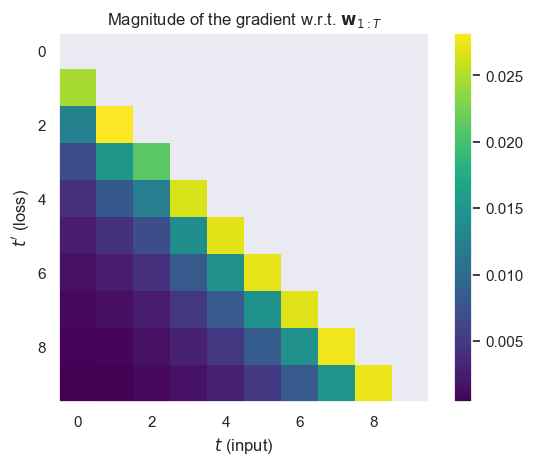

In [8]:
# Test whether the autoregressive constrains (h_t only depends on w_{<t}) is enforced
rnn.zero_grad()
# get dummy token ids
token_ids = torch.arange(0, 10)
token_ids = token_ids[None].repeat(10, 1)
# run through the RNN
logits = rnn(token_ids, retain_ws=True)

# compute a loss for a which depends only on step `t=i`
loss_locations = torch.arange(0, 10)[:, None, None].expand(10, 1, logits.shape[-1])
loss = logits.gather(index=loss_locations, dim=1).mean()

# backward pass and retrieve the gradients with respect to the word vectors w_{1:T}
loss.backward()
grad_magnitude = rnn.ws.grad.norm(dim=2)
rnn.ws = None

# visualize the gradient
grad_magnitude[grad_magnitude==0] = -math.inf # the the gradient that are exactly zero to -inf for the sake of visualization
grad_magnitude = grad_magnitude.detach().cpu().numpy()
plt.imshow(grad_magnitude, sns.color_palette("viridis", as_cmap=True))
plt.colorbar()
plt.grid(False)
plt.xlabel("$t$ (input)")
plt.ylabel("$t'$ (loss)")
plt.title("Magnitude of the gradient w.r.t. $\mathbf{w}_{1:T}$")
plt.show()

**Exercise 1**: Explain in your own words what the plot shows. How would it look if we had a leakage of information from the future to the present?

> The plot shows the autoregressive constraints of the RNN. The gradient for each word depends only the current input and also on the past. If there was leakage, the upper triangle of this matrix would also have values (corresponding to input word vectors from the future).

**Exercise 2**: Implement the loss of the RNN language model.

> answer in the code below.

In [15]:
# torch.cuda.memory_summary(device="cuda", abbreviated=False)
torch.cuda.empty_cache()

In [9]:
# use Adam optimizer
optimiser = torch.optim.AdamW(rnn.parameters(), lr=1e-3)

# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=4,
    shuffle=True,
    num_workers=2,
    collate_fn=list,
)

# convert token_ids to tensors
def make_batch(batch: List[Dict[str, Any]], max_length=24, key:str="token_ids") -> torch.Tensor:
    """Collate the `token_ids` into a single tensor, pad to minimum length."""
    token_ids = [b[key] for b in batch]
    max_length = min(max_length, *(len(x) for x in token_ids))
    token_ids = [torch.tensor(x) for x in token_ids]
    return torch.stack([x[:max_length] for x in token_ids])

# If you don't have enough GPU memory, decrease the batch size, potentially along with the learning rate.
rnn = rnn.to(DEVICE)
num_steps = 1000 # 5_000
step = 0
epoch = 0
with tqdm(total=num_steps) as pbar:
    while step < num_steps:
        for batch in train_loader:
            # concatenate the `token_ids``
            batch_token_ids = make_batch(batch)
            batch_token_ids = batch_token_ids.to(DEVICE)

            # forward through the model
            optimiser.zero_grad()
            batch_logits = rnn(batch_token_ids)

            # compute the loss (negative log-likelihood)
            p_ws = torch.distributions.Categorical(logits=batch_logits) 

            # Exercise: write the loss of the RNN language model
            # hint: check the doc https://pytorch.org/docs/stable/distributions.html#categorical
            # NB: even with the right loss, training is slow and the generated samples won't be very good.
            loss = -p_ws.log_prob(batch_token_ids).mean() # <- YOUR CODE HERE 

            # backward and optimize
            loss.backward()
            optimiser.step()
            step += 1
            pbar.update(1)

            # Report
            if step % 5 ==0 :
                loss = loss.detach().cpu()
                pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

            # save checkpoint
            if step % 50 ==0 :
                torch.save(rnn.state_dict(), checkpoint_file)
            if step >= num_steps:
                break
        epoch += 1

epoch=3, step=1000, loss=3.5: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


In [10]:
# sample the RNN language model
with torch.no_grad():
    sample = rnn.sample(num_steps=10, batch_size=10, temperature=0.5, prevent_repetitions=True)
    rich.print(glove_tokenizer.decode_batch(sample.detach().cpu().numpy()))

Sampling 10 steps..: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


[
    ', to iraq heat democracy on ( the ap uk',
    ': sun of dims <|unknown|> from miles games ( the',
    '- , quarter bush net announces ( atlanta reuters (',
    'market the , eyes but like the boss renault boss',
    ': of google humor raises market google to ipo stock',
    "return : to windows the ' of doom ' games",
    'infocus news : umesh new patel england a of p',
    ': google of raises auction anti prix - ( year',
    'sprint , to thorpe open in ( 200 ap .',
    'the new uk method is of legal genesis for are'
]

In [11]:
_ = rnn.cpu()
# free-up memory if needed: delete the RNN model
# del rnn

**Exercise 3**: What would happen if the inputs of the RNN were not shifted to the right (in sample in the RNNLM class)?  

> If the inputs were not shifted, the RNN would have access to the current token when predicting the next token. This violates the autoregressive principle of language modeling, where predictions should be made solely based on past context. As a result, the model might simply learn to copy the input, and wouldn't be able to generate new text or capture the dependencies between tokens in a sequence.

___
## III. Attention mechanism and Transformers


The attention mechanism was first introduce in machine learning for machine translation tasks [("Neural Machine Translation by Jointly Learning to Align and Translate", Bahdanau et al. (2014))](https://arxiv.org/abs/1409.0473). Translation is a sequence-to-sequence problem which goal is to generate a translation of a source text. The attention mechanism was introduced to allow *attenting* the whole source text at any of the generation steps. We implement attention with the softmax function because it is a differential version of a hard zero-one attention.

In this section, we will introduce the *scaled dot-product* self-attention mechanism and the Transformer architecture [("Attention is All You Need", Wasrani et al. (2016))](https://arxiv.org/abs/1706.03762).

### III.a Attention mechanism

Attention has become a very important concept in deep learning beginning with ["Neural Machine Translation by Jointly Learning to Align and Translate", Badanau et. al. (2015)](https://arxiv.org/abs/1409.0473). The idea key idea in that paper is that when you translate a sentence from for example German to English then it is a good is helpful for the model when it generates  

We define three variables:
1. The query $\mathbf{Q} = [\mathbf{q}_i, \ldots \mathbf{q}_{T_\mathbf{Q}}] \in \mathcal{R}^{T_\mathbf{Q} \times h_i}$, a sequence of vectors of length $T_\mathbf{Q}$ and vector dimension $h_i$.
1. The keys $\mathbf{K} = [\mathbf{k}_1, \ldots \mathbf{k}_{T_{\mathbf{K}\mathbf{V}}}] \in \mathcal{R}^{T_{\mathbf{K}\mathbf{V}} \times h_i}$, a sequence of vectors of length $T_{\mathbf{K}\mathbf{V}}$ and vector dimension $h_i$.
1. The values $\mathbf{V} = [\mathbf{v}_1, \ldots \mathbf{v}_{T_{\mathbf{K}\mathbf{V}}}] \in \mathcal{R}^{T_{\mathbf{K}\mathbf{V}} \times h_o}$, a sequence of vectors of length $T_{\mathbf{K}\mathbf{V}}$ and of another dimension $h_o$, although in general we choose $h_i = h_o$.

For each query, the attention mechanism returns a convex combinations of the values $\mathbf{V}$. The attention mechanism is defined as
$$
\mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \mathrm{Softmax}\left( \frac{\mathbf{Q} \mathbf{K}^T}{\tau} \right) \mathbf{V} \ ,
$$
where $\tau$ is a scaling parameter, set to $\sqrt{h_i}$ in (["Attention is All You Need", Wasrani et al. (2016)](https://arxiv.org/abs/1706.03762)). $\mathrm{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V})$ is a sequence of $T_\mathbf{Q}$ vectors, each of dimension $h_o$.

The above expresson is equivalent to applying attention to each query vector $\mathbf{q}$ separately. The output for each vector $\mathbf{q}$ depends on the vector of weights $\mathbf{\Lambda} = \mathrm{Softmax}\left( \frac{\mathbf{q} \mathbf{K}^T}{\tau} \right)$ with values $[\lambda_1, \ldots \lambda_{T_{\mathbf{K}\mathbf{V}}}]$. The vector of weights $\Lambda$ is a function of the inner-product $\mathbf{q} \mathbf{K}^T$, which defines a similarity metric between the the vectors $\mathbf{q}$ and each of the key vectors $[\mathbf{k}_1, \ldots \mathbf{k}_{T_{\mathbf{K}\mathbf{V}}}]$. Furthermore, as the weights sum to one, the output of the attention function is a convex combinations of the values:
$$
\mathrm{Attention}(\mathbf{q}, \mathbf{K}, \mathbf{V}) = \sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i \ .
$$

**Experiment** We will use the GloVe word vectors to illustrate the attention mechanism. 

We define queries and keys using the GloVe word vectors correspond to country names:
$$
\begin{align}
\mathbf{Q} =& [\mathrm{vec("Italy")}, \mathrm{vec("Korea")}, \mathrm{vec("Nicaragua")}, \ldots] \\
\mathbf{K} =& [\mathrm{vec("China")}, \mathrm{vec("Russia")}, \mathrm{vec("Turkey")}, \ldots] \ .
\end{align}
$$
The inner-product between paris is of country vectors will have a large values when the vectors are similar, this might happend when two countries are geographically or culturally close to each other because of the properties of the GloVe vectors. The last component required to apply the attention mechanism is set of value vectors $\mathbf{V}$.

The choice of values depends on the end problem, for this exercise we choose stay in the same theme as for the word2vec experiments. We choose the value vectors to represent the relative concept "*capital city of a country*", which correspond to the vector $\mathrm{vec("Capital\, city")} - \mathrm{vec("Country")}$ in the gloVe vector space. In practice, for each country we set:
$$
\begin{align}
\mathbf{V} =& [\mathrm{vec("Beijing")} - \mathbf{K}_1, \mathrm{vec("Moscow")} - \mathbf{K}_2, \mathrm{vec("Ankara")} - \mathbf{K}_3, \ldots] \\
\end{align}
$$

*Figure: Word vectors vec("capital city") - vec("country") represented in a vector space. Vectors might point in different direction depending on their position in the vector space.*
![Attention analogies](images/attention-analogies.png)

We represent the query, key and value vectors in the GloVe vector space in the above figure. The intuition is that the value vector $\mathrm{vec}(\text{"capital city of a country"})$ is not always the same depending on the country. Therefore, in this experiment, we will attempt to extract value vectors that are contextualized on the query. To do so, we will add the output of the attention (a mixture of vectors $\mathrm{vec}(\text{"capital city"}) - \mathrm{vec}(\text{"country"})$) to the vector representation of the query (a country). This corresponds to:

$$
\mathrm{vec("Capital\,city\,of\,the\,query\,country")} =  \mathrm{vec("Query\,country")} + \underbrace{\mathrm{Attention}(\mathrm{vec("Query\,country")}, \mathbf{K}, \mathbf{V})}_{\sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i}
$$

First, let's investigate the attention weights $\lambda_1, \ldots, \lambda_{T_{\mathbf{K}\mathbf{V}}}$ for each query $\mathbf{q}_1, \ldots, \mathbf{q}_\mathbf{Q} $ separately:

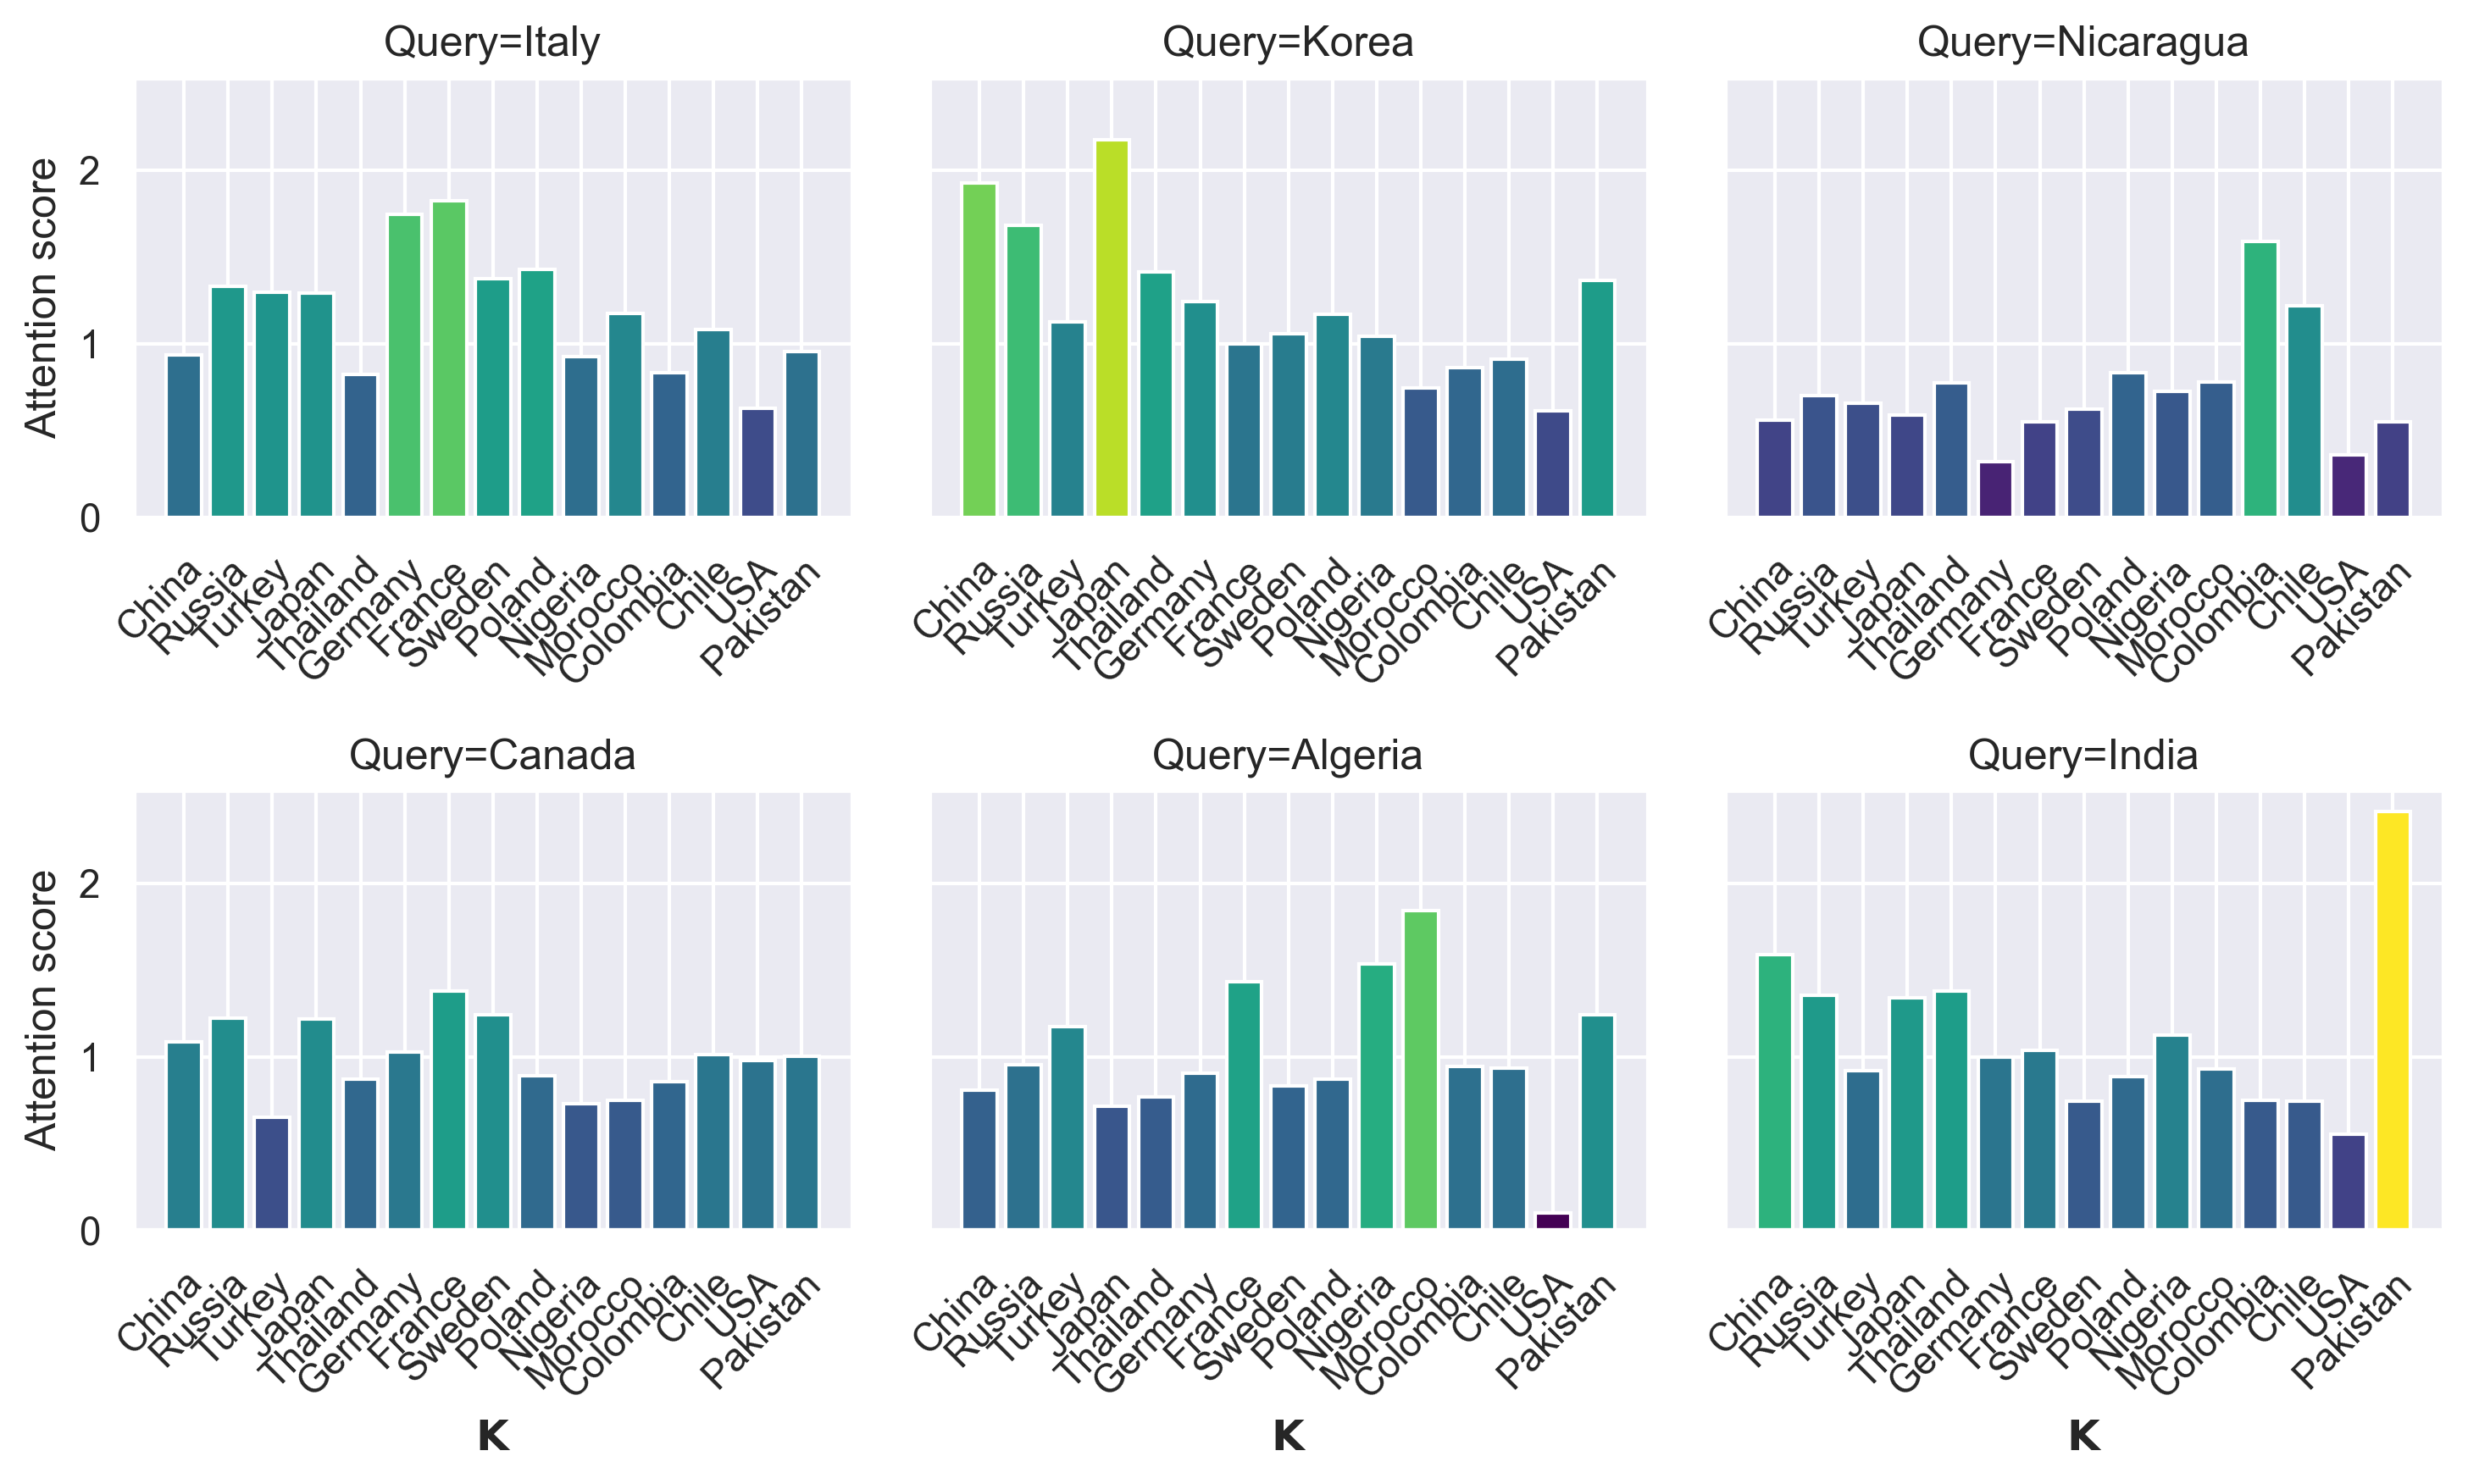

In [12]:
# instantiate some embeddings
embeddings = torch.nn.Embedding(*glove_vectors.shape)
embeddings.weight.data = glove_vectors
embeddings.weight.requires_grad = False

def names_to_vectors(values: List[str]) -> torch.Tensor:
    encodings = glove_tokenizer.encode_batch(values)
    vectors = [embeddings(torch.tensor(e.ids)).mean(dim=0) for e in encodings]
    return torch.stack(vectors)


def plot_attention_weights(attention_weights, queries_labels, keys_labels, nrows = 2):
    """Plot the attention scores between each of the queries and the keys."""
    ncols = len(attention_weights) // nrows
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (10,6), sharex=False, sharey=True, dpi=300)
    colors = sns.color_palette("viridis", as_cmap=True)
    def normalize(x, values):
        return (x -  values.min()) / (values.max() - values.min())
    for k, ax in enumerate(axes.flat):
        query_label = queries_labels[k]
        attention_weights_k = attention_weights[k]
        cols = [colors(normalize(x, attention_weights).detach().item()) for x in attention_weights_k]
        ax.bar(keys_labels, attention_weights_k, color=cols)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax.set_title(f"Query={query_label}")
        if k % ncols == 0 :
            ax.set_ylabel("Attention score")
        if k >= ncols:
            ax.set_xlabel("$\mathbf{K}$")
    fig.tight_layout()
    plt.show()

# Define keys, queries and values
queries_labels = ["Italy", "Korea", "Nicaragua", "Canada", "Algeria", "India"]
keys_labels = ["China", "Russia", "Turkey", "Japan", "Thailand", "Germany", "France", "Sweden", "Poland", "Nigeria", "Morocco", "Colombia", "Chile", "USA", "Pakistan"]
keys_cities_labels = ["Beijing", "Moscow", "Ankara", "Tokyo", "Bangkok", "Berlin", "Paris", "Stockholm", "Warsaw", "Abuja", "Rabat", "Bogota", "Santiago", "Washington", "Islamabad"]
# convert to vectors
Q = names_to_vectors(queries_labels)
K = names_to_vectors(keys_labels)
V = names_to_vectors(keys_cities_labels) - K


# compute the attention weights for each query using a ´for` loop
attention_weights = []
for q in Q:
    log_lambda_q = (q @ K.T) / math.sqrt(float(Q.shape[-1]))
    attention_weights.append(log_lambda_q)
attention_weights = torch.stack(attention_weights)

# plot attention weights for each query
plot_attention_weights(attention_weights, queries_labels, keys_labels)

**Exercise 4**:  In this example, what is the value of $T_{\mathbf{K}\mathbf{V}}$, $T_{\mathbf{Q}}$, $h_i$, $h_o$ and $\tau$ ?

> * $T_{\mathbf{K}\mathbf{V}} = 15$ 
> * $T_{\mathbf{Q}} = 6$ 
> * $h_i = 300$
> * $h_o = h_i = 300$
> * $\tau = sqrt(300)$

**Implementing the attention function** We obtained a set of attention weights for each query, concatenating them results in a 2D matrix that will display bellow. Let's implement the `attention` function in the cell bellow using the inputs vectors $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ and visualize the output vector. we use [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html) to implement the sum $\sum_{i=1}^{T_{\mathbf{K}\mathbf{V}}} \mathbf{\lambda}_i \mathbf{v}_i$.

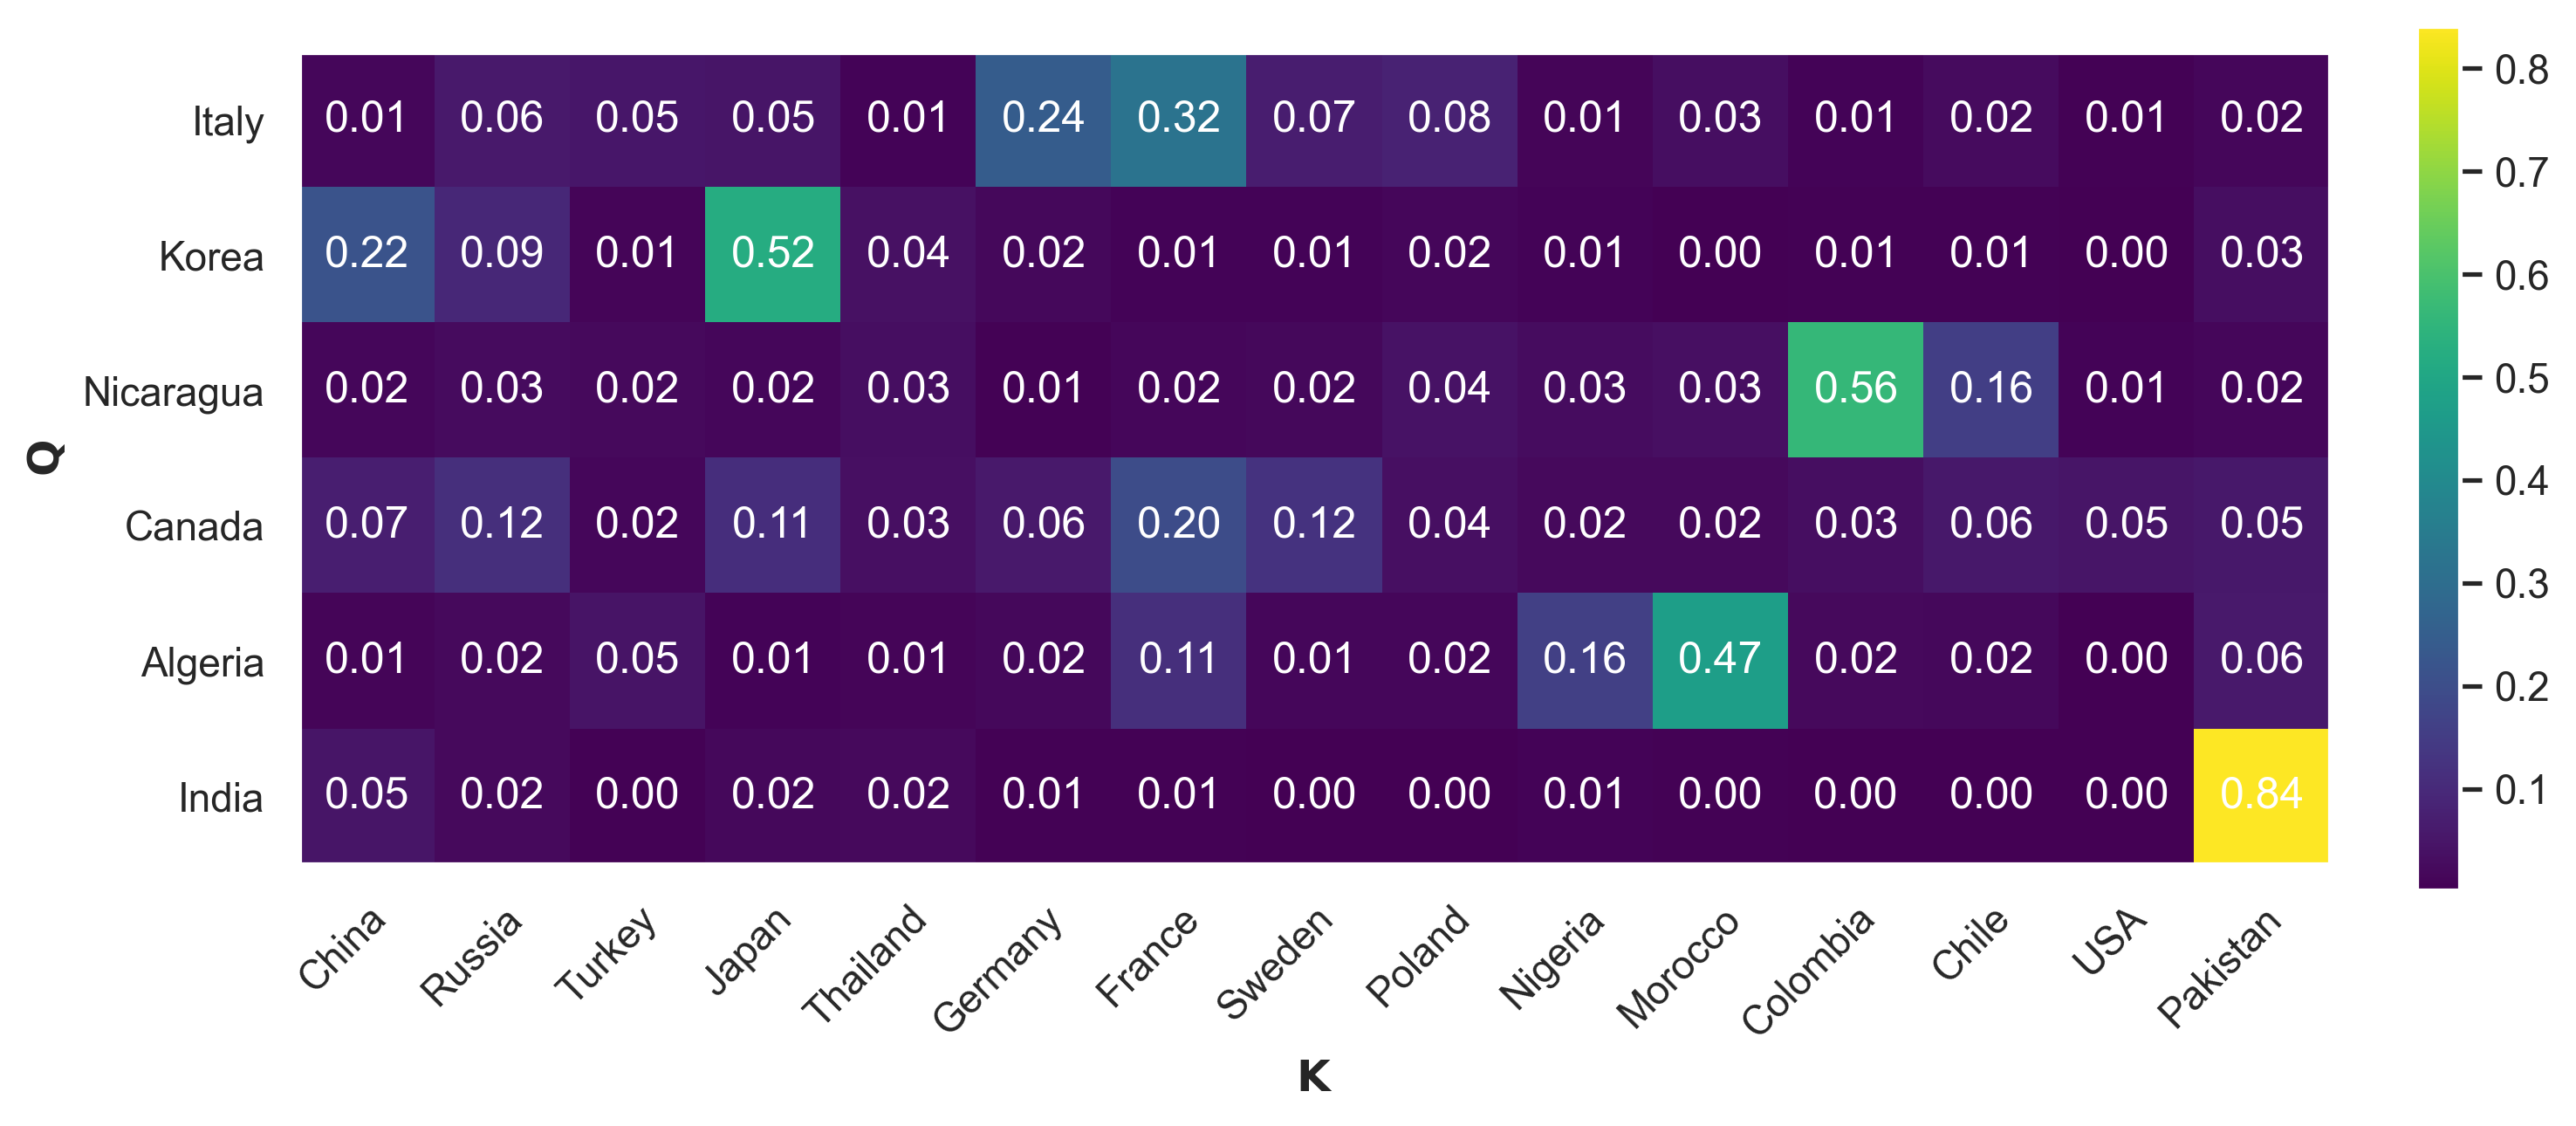

In [14]:

def plot_attention_map(attention_map, queries_labels, keys_labels, print_values:bool=False, ax=None, color_bar:bool=True):
    """Plot the attention weights as a 2D heatmap"""
    if ax is None:
        fig, ax = plt.subplots(figsize = (10,6), dpi=300)
    else:
        fig = plt.gcf()
    im = ax.imshow(attention_map, cmap=sns.color_palette("viridis", as_cmap=True))
    ax.grid(False)
    ax.set_ylabel("$\mathbf{Q}$")
    ax.set_xlabel("$\mathbf{K}$")
    ax.set_yticks(np.arange(len(queries_labels)))
    ax.set_yticklabels(queries_labels)
    ax.set_xticks(np.arange(len(keys_labels)))
    ax.set_xticklabels(keys_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if print_values:
        for i in range(len(queries_labels)):
            for j in range(len(keys_labels)):
                text = ax.text(j, i, f"{attention_map[i, j]:.2f}",
                            ha="center", va="center", color="w")

    if color_bar:
      fig.colorbar(im, fraction=0.02, pad=0.04)
    fig.tight_layout()

def attention(Q, K, V, tau=None):
    """A simple parallelized attention layer"""
    if tau is None:
        tau = math.sqrt(float(Q.shape[-1]))
    assert Q.shape[-1] == K.shape[-1]
    assert K.shape[0] == V.shape[0]
    attention_map = Q @ K.T / tau
    attention_weights = attention_map.softmax(dim=1)
    return torch.einsum("qk, kh -> qh", attention_weights, V), attention_weights

# return the output of the attention
output, attention_weights = attention(Q, K, V, tau=5.)   #### NOTICE THE TAU

# plot the attention weights
plot_attention_map(attention_weights, queries_labels, keys_labels, print_values=True)

**Exercise 5**:  What effect has the parameter $\tau$ on the attention mechanism? What is happening when using a large value for $\tau$? using a small value for $\tau$? In the limits $\tau \rightarrow 0$ and $\tau \rightarrow \infty$

> The parameter $\tau$ controls how pronounced the effect of attention is. The higher it is, the more uniform the distribution. 

> Large τ: The attention distribution becomes more uniform, meaning each key receives similar attention. As $\tau \to \infty$, the attention mechanism approaches an average over all values.

> Small τ: The attention distribution becomes more peaked, amplifying differences in similarity between the query and the keys. As $\tau \to 0$, the attention mechanism approaches a hard attention, focusing almost exclusively on the key with the highest similarity.


**Visualizing the output word vector** In the code below we use the code from the previous word2vec experiment to generate the nearest neighbour corresponding to the analogy: 

$$\mathrm{vec("Capital\,city\,of\,the\,query\,country")} = \mathrm{vec("Query\,country")} + \mathrm{Attention}(\mathrm{vec("Query\,country")}, \mathbf{K}, \mathbf{V})$$

In [15]:
# Report of the nearest neighbors of the vector `query + Attention(query, keys, values)``
for i, attn_output in enumerate(output):
    # z = query + Attention(qeury, keys, values)
    z = Q[i] + attn_output
    rich.print(f"Nearest neighbors of [red]{queries_labels[i]}[/red] + [blue]Attention({queries_labels[i]}, K, V)")
    rich.print(vec2words(z, k=5, **glove_args, exclude_vecs=[word2vec(queries_labels[i], **glove_args)]))

Nearest neighbors of Italy + Attention(Italy, K, V)

(['italian', 'rome', 'milan', 'turin', 'venice'], tensor([36.0901, 35.9431, 34.1260, 28.5838, 28.1707]))

Nearest neighbors of Korea + Attention(Korea, K, V)

(['pyongyang', 'seoul', 'korean', 'tokyo', 'dprk'], tensor([48.9665, 48.3320, 42.2593, 37.2509, 34.9750]))

Nearest neighbors of Nicaragua + Attention(Nicaragua, K, V)

(
    ['managua', 'tegucigalpa', 'bogota', 'nicaraguan', 'aleman'],
    tensor([33.5729, 27.2323, 26.7101, 25.3436, 24.3552])
)

Nearest neighbors of Canada + Attention(Canada, K, V)

(['canadian', 'toronto', 'ontario', 'quebec', 'montreal'], tensor([28.4365, 26.5749, 26.3066, 26.0853, 25.9097]))

Nearest neighbors of Algeria + Attention(Algeria, K, V)

(['algiers', 'algerian', 'rabat', 'abdelaziz', 'kabylie'], tensor([30.6203, 28.8403, 27.1892, 24.0872, 24.0432]))

Nearest neighbors of India + Attention(India, K, V)

(['delhi', 'islamabad', 'indian', 'kashmir', 'jammu'], tensor([41.9116, 40.1346, 31.4620, 30.6152, 28.8065]))

**Eercise 6** Would the results be different when shuffling the vectors $\mathbf{K}$ and $\mathbf{V}$ (with the same permutation for both vectors)?

> No, the results would not be different if you shuffle the vectors K and V with the same permutation. If we consider that these work like a dictionary, where vectors K is a name for something and V is the defintion, of it, then we can easily tell that shuffling the places of specific pieces around would not change anything. The only thing is that we humans like if they are set alphabetically, so that its faster to find your desired word. Of course, if they were shuffled with different permutations, then the word and definition would get mangled and the dictionary would be more like a puzzle.

### III.b Self-attention

*Figure: A self-attention layers allows attending all the sequence positions*
![Self-attention allows attentind at all the sequence positions](images/self-attention.png)

The attention mechanism is a transformation of a sequence of vectors $\mathbf{Q}$ given all the values in the sequence $\mathbf{V}$. In a self-attention layers, the attention layer is parameterized with transformations of the input sequence $\mathbf{w}_{1:T}$ as parameters, which allows processing each vector in a sequence $\mathbf{w}_{1:T}$ based on all the other locations. The output of the self-attention layer is a sequence of hidden states:
$$
 \mathbf{h}_{1:T} = \mathrm{Attention} \left(\mathbf{Q}(\mathbf{w}_{1:T}), \mathbf{K}(\mathbf{w}_{1:T}), \mathbf{V}(\mathbf{w}_{1:T}) \right)
$$

**Illustration** Let's apply the self-attention to a list of word vectors, do you any structure emerging?

{'Q': torch.Size([6, 300]), 'K': torch.Size([15, 300]), 'V': torch.Size([15, 300]), 'H': torch.Size([11, 300])}

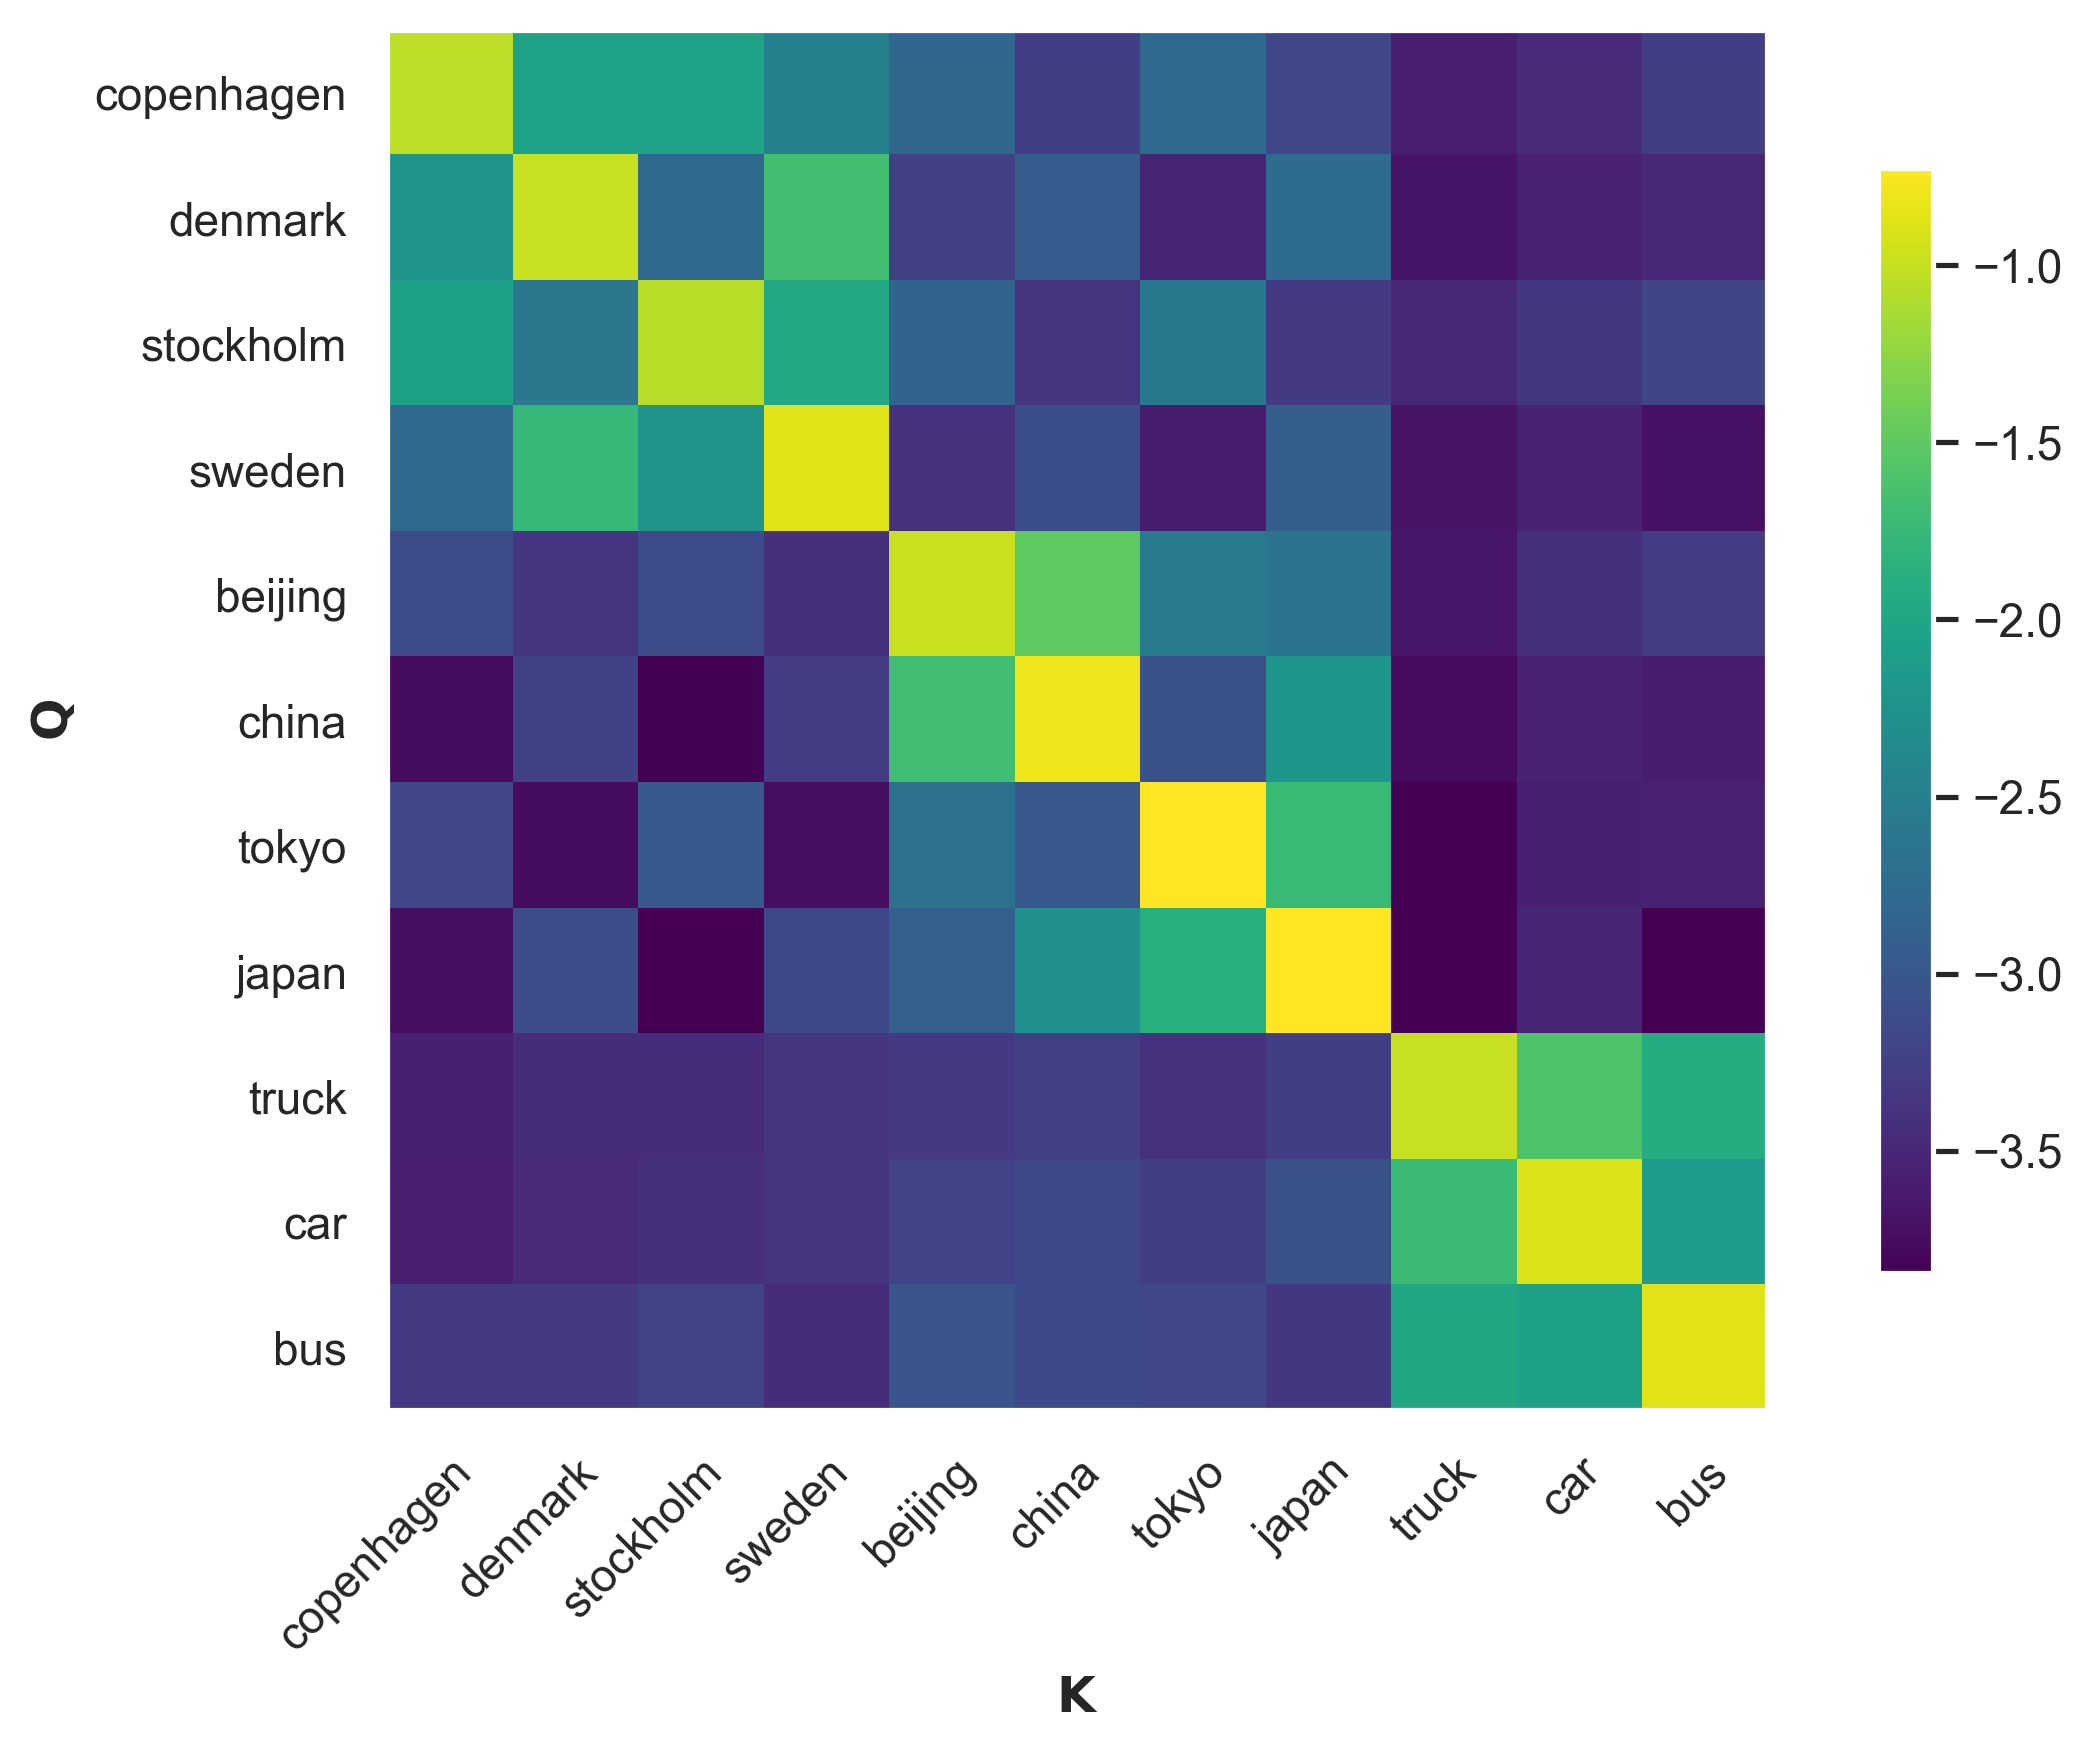

In [16]:
# Illustration of the above using code
hdim = 300
sentence = "Copenhagen Denmark Stockholm Sweden Beijing China Tokyo Japan truck car bus"
token_ids = torch.tensor(glove_tokenizer.encode(sentence).ids)
tokens = [glove_vocabulary[x] for x in token_ids]
vectors = embeddings(token_ids)
H, attention_map = attention(vectors, vectors, vectors)
rich.print({
    "Q": Q.shape,
    "K": K.shape,
    "V": V.shape,
    "H": H.shape
})

# visualized the log of the attention map
plot_attention_map(attention_map.log(), tokens, tokens)

**Exercise 7**: Comment on the structure of the attention map. Why is that the case?

> Self-attention allows words to "look at" other words in the sentence to better understand their meaning and role. While words might attend to other related words (e.g., "Copenhagen" attending somewhat to "Denmark"), the strongest connection is usually to themselves. This helps the model capture the individual meaning of each word before considering its relationship to other words.

### IV.b Masked attention

The self-attention layer allows computing the hidden state $\mathbf{h}_{t}$ based on all the input vectors $\mathbf{w}_{1:T}$. In language modelling, we want to enforce constrains on the dependencies of $\mathbf{h}_t$ to allow left-to-right or masked factorizations. A attention mask $\mathbf{M} \in \{0, -\infty \}^{T \times T}$ is of the same dimension as the matrix $ \mathbf{Q} \mathbf{K}^T$ and can be utilized to enforce the attention weights $\mathbf{\lambda}_1, \ldots, \mathbf{{\lambda}_T}$ to be zero wherever it is necessary. The masked attention mechanism is expressed as
$$
\mathrm{Attention} \left(\mathbf{Q}, \mathbf{K}, \mathbf{V}, \mathbf{M} \right) = \mathrm{Softmax}\left( \mathbf{M} + \frac{\mathbf{Q} \mathbf{K}^T}{\tau} \right) \mathbf{V} \ .
$$

**Exercise 8**:  Let's implement an attention mask corresponding to:
1. Left-to-right language model $p(\mathbf{w}_t \mid \mathbf{w}_{<t})$
1. bidirection language model $p(\mathbf{w}_t \mid \mathbf{w}_{-t})$
1. right-to-left language model $p(\mathbf{w}_t \mid \mathbf{w}_{t>})$

> Answer in the code below.

**NB** In the visualization bellow, we re-use the gradient map extracted from the left-to-right RNN language model.


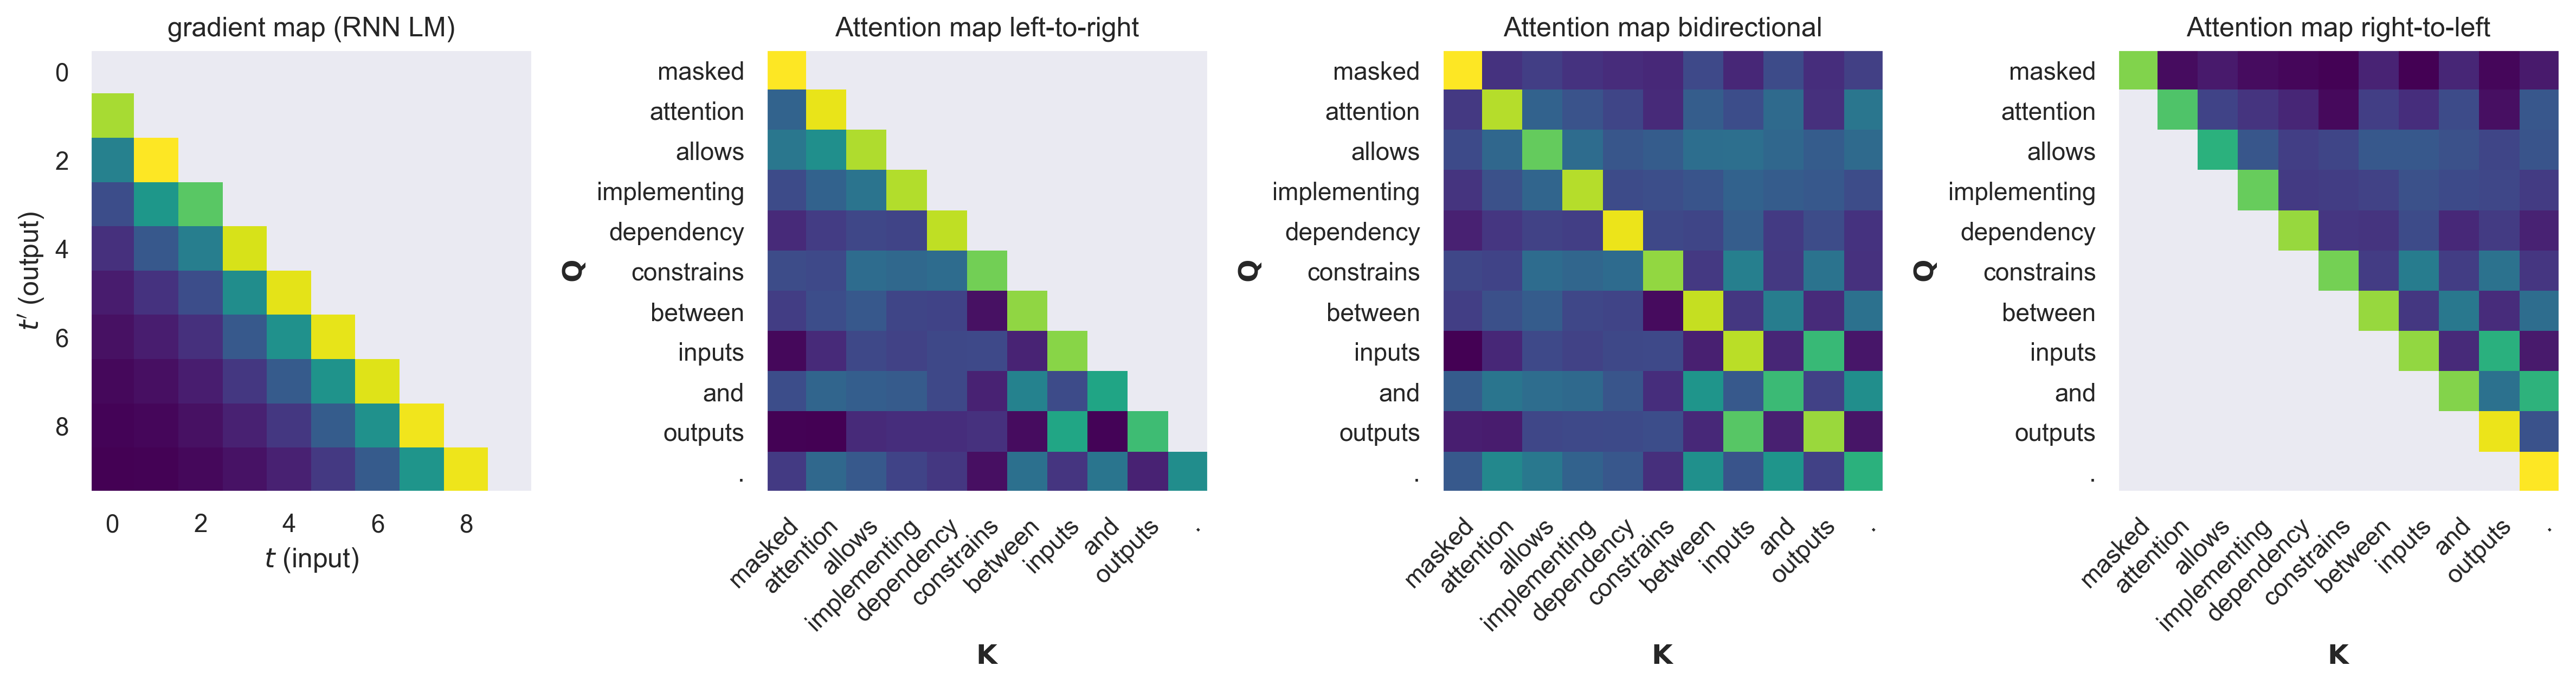

In [18]:
def masked_attention(Q, K, V, tau=None, mask=None):
    """A simple masked attention layer"""
    if tau is None:
        tau = math.sqrt(float(Q.shape[-1]))
    assert Q.shape[-1] == K.shape[-1]
    assert K.shape[0] == V.shape[0]
    attention_map = Q @ K.T / tau
    if mask is not None:
        attention_map = mask + attention_map
    attention_weights = attention_map.softmax(dim=1)
    return torch.einsum("qk, kh -> qh", attention_weights, V), attention_weights

# get a more natural sentence
sentence = "Masked attention allows implementing dependency constrains between inputs and outputs."
token_ids = torch.tensor(glove_tokenizer.encode(sentence).ids)
tokens = [glove_vocabulary[x] for x in token_ids]
vectors = embeddings(token_ids)

# EXERCISE: Implement the masks corresponding to each factorization
# Hint: check the documentation for `torch.diag()`, `torch.triu()` and `torch.tril()`
T = len(token_ids)
masks = {
    "left-to-right": torch.triu(torch.ones(T, T), diagonal=1).bool(),   # Your code here
    "bidirectional": torch.zeros(T, T).bool(),                          # Your code here
    "right-to-left": torch.tril(torch.ones(T, T), diagonal=-1).bool(),  # Your code here
}
for key in masks.keys():
    if masks[key] is not None:
        masks[key] = masks[key] = torch.where(masks[key] == 0, 0, -math.inf)   # -math.inf, masks[key]

# visualized the log of the masked attention map
fig, axes = plt.subplots(ncols=1+len(masks), figsize = (16,6), sharex=False, sharey=False, dpi=300)
# plot the gradient map from the RNN LM
axes.flat[0].imshow(grad_magnitude, sns.color_palette("viridis", as_cmap=True))
axes.flat[0].set_xlabel("$t$ (input)")
axes.flat[0].set_ylabel("$t'$ (output)")
axes.flat[0].grid(False)
axes.flat[0].set_title("gradient map (RNN LM)")
# plot the attention map
for ax, (mask_name, mask) in zip(axes.flat[1:], masks.items()):
    if mask is not None:
        H, attention_map_masked = masked_attention(vectors, vectors, vectors, mask=mask)
        plot_attention_map(attention_map_masked.log(), tokens, tokens, ax=ax, color_bar=False)
    ax.set_title(f"Attention map {mask_name}")
plt.tight_layout()
plt.show()

----
## IV. Transformers

<img src="images/transformer.png" alt="Transformer architecture" width="600"/>

In this section we are going to introduce the [Transformer ("Attention is all you need", Vaswani (2017))](https://arxiv.org/abs/1706.03762) architecture.

For further information, see the excellent PyTorch tutorial ["language translation using Transformers"](https://pytorch.org/tutorials/beginner/translation_transformer.html) and blog article ["Annotated Transformer"](https://nlp.seas.harvard.edu/2018/04/03/attention.html), which review the original in great details and provide additional content such as visualizations of the learned attention maps.

**Architecture** A Transformer is composed of two main components: a decoder which implements a language model and an encoder. The encoder is only required for conditional language models like those used in translation tasks. Each of the two components is made by stacking Transformer layers (layers with and without conditioning). Each layer transforms a sequence of hidden state $\mathbf{h}_{1:T}^l$ into another sequence $\mathbf{h}_{1:T}^{l+1}$. The input tokens are converted into the first state $\mathbf{h}_{1:T}^0$ using an embedding layer coupled with positioal encodings. the last hidden state $\mathbf{h}_{1:T}^{L}$ is projected into the vocabulary space using a liner layer.

### IV.a Positional encodings

The position of a word in the sentence can make a difference in the type of meaning that word is assuming. In order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. While an RNN see the tokens sequntially and therefore can get an idea of the position of the different words in the sentence, a Transformer model is not processing the input sequentially, therefore this model needs a way to understand which part of the sentence it is processing.

The positional encoding should satisy the following properties:
- for each time-step, i.e. word position in a sentence, it should produce a unique vector;
- the distance between any two time-steps should be consistent;
- it should be deterministic.

In the paper they proposed to use a positional encoding that produce a vector of size $d_{\text{model}}$ as the embedding size, so we can add them together. The method proposed by the paper can be defined as:

\begin{align}
 PE(t,2i) = \sin{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)} \quad\text{and}\quad PE(t,2i+1) = \cos{\left(\frac{t}{10000^{\frac{2i}{d_{\text{model}}}}}\right)}
\end{align}

where $t$ is the position of the world in the sentence and $i$ is the index in the embedding. To do this we have to consider $i=0,2,4,\dots$. Indeed, then for each $i$ we compute both the functions above and thertefore $2i$ and $2i+1$ represents the column index of the positional encoding vector. In other words, for each even index $i$ we apply the first equation and for every odd index we apply the second one. Therefore, each dimension of the positional encoding corresponds to a sinusoid and the vector that we will obtain will have the following form:

$$ PE = [ \sin{(t)}, \cos{(t)}, \sin{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cos{\left(\frac{t}{10000^{\frac{2}{d_{\text{model}}}}}\right)}, \cdots]$$


The class defining the Positional Encoding is given by this code snippet. We can also try to plot and look at the positional encoding we get, this is done in the second code snippet.

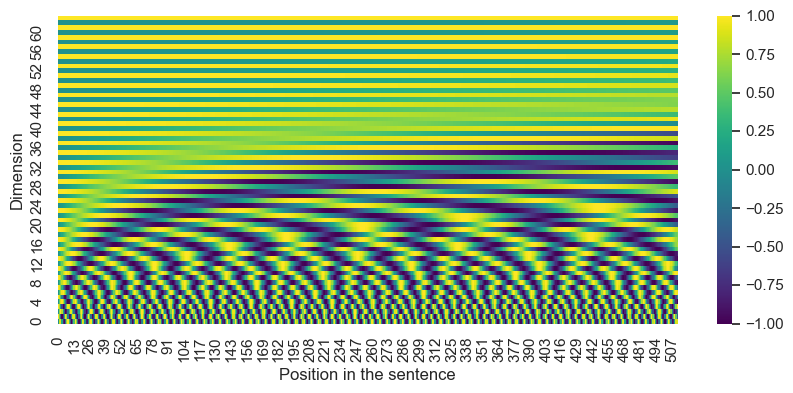

In [19]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# let's assume we havee a sequence of length 10 and embedding of length 128
# how their positional encoding looks like

plt.figure(figsize=(10, 4))

# we define the positional encoding for a 128-dimensional vector and for this 
# example we do not use dropout
pe = PositionalEncoding(64, dropout=0, max_len=1000)

# note here we are assuming our input to be
# batch_size x sequence_length x d_model
# but in pytorch they are assuming 
# sequence_length x batch_size x d_model
# we also assume zeros so we can see how the positional encoding looks like
x_inputs = torch.zeros(1, 512, 64)
y = pe(x_inputs)

sns.heatmap(y.squeeze(0).T, cmap=sns.color_palette("viridis", as_cmap=True))
plt.ylabel('Dimension')
plt.xlabel('Position in the sentence')
plt.gca().invert_yaxis()
plt.show()

# in the figure below each row corresponds to the vector we are adding 
# to our embedding vector when the word is at that position in the sentence

### IV.b Base layers

*Figure: (Left) A layer of base Transformer layer with three components: multi-head attention layer, feed-forward layer, and add & norm layer. 
(Right) Multi-head attention layer.*

<img src="images/transformer-layer.png" alt="base Transformer layer (without conditioning)" width="200" style="margin-right: 100px"/>
<img src="images/multi-head-attention.png" alt="Multi-head attention" width="200"/>

Each base layer of index $l$ takes a sequence of hidden state $\mathbf{h}_{1:T}^l$ as input, and output another sequence $\mathbf{h}_{1:T}^{l+1}$.

**Multi-head attention** The attention mechanism introduced in the previous section depends on a softmax of inner-products, which might be sparse depending on the value of the vectors, in that case, the layer can only attend to a few positions in the sequence. To enable attending to more positions in the input sentence, multiple attention mechanism can be used in parallel. This is what we call a multi-head attention layer:
$$
\begin{align}
\mathrm{MultiHeadAttention} \left(\mathbf{Q}^{1:P}, \mathbf{K^{1:P}}, \mathbf{V}^{1:P}, \mathbf{M} \right) = [ \mathrm{Attention} \left(\mathbf{Q}^{1}, \mathbf{K^{1}}, \mathbf{V}^{1}, \mathbf{P} \right), 
\ldots
\mathrm{Attention} \left(\mathbf{Q}^{P}, \mathbf{K^{P}}, \mathbf{V}^{P}, \mathbf{M} \right)] \ ,
\end{align}
$$
where each set of vectors $\mathbf{Q}^{i}, \mathbf{Q}^{i}, \mathbf{Q}^{i}$ corresponding to the head index $i$ is obtained using a separate linear transformation of the input sequence.

**Feed-forward** The multi-head attention layer allows looking up multiple positions of the input sequence, but the output is only a linear combination of the value vector $\mathbf{V}$. A multi-layer neural network (feed-forward layer) is applied **element-wise** to each element of the sequence of hidden states to allow modelling more complex non-linear dependencies.

**Add & Norm** A Transformer is a deep neural network, and therefore might be difficult to optimize. Similarly deep neural networks in the image processing field, Transformer layer rely on two stabilizing components:
1. [Residual connections](https://arxiv.org/abs/1512.03385) allow to bypass the attention layer as well as the feed-forward layer.
2. [Layer normalization](https://arxiv.org/abs/1607.06450): allow enforcing that the output of a Transformer layer has values that are properly distributed

**Implementation:** Here is an implementation for the attention and multi-head attention. You can also check the official [PyTorch implementation](https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention).

In [20]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -math.inf)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [21]:
class MultiHeadedAttention(nn.Module):
    """A simple Multi-head attention layer."""
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attn = None # store the attention maps
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### IV.c Conditional layers

In the description of the base layer, we have applied attention to the input sequence (*self-attention*). Machine translation is a sequence-to-sequence task, which requires and *encoder* component, that encodes a source text into a sequence of hidden states $\mathbf{g_{1:T'}}$. The base layer can be modified with an additional attention layer that is conditionned on the source text. Given a sequence of hidden states $\mathbf{h}_{1:T}$, the conditional attention layer is:
$$
\mathrm{Attention}(\mathbf{Q}(\mathbf{h}_{1:T}), \mathbf{K}(\mathbf{g}_{1:T'}), \mathbf{V}(\mathbf{g}_{1:T'})) \ .
$$
Conditional attention layers are place right after the self-attention layers, before the feed-forward layer (see diagram).

### IV.d Pre-training as language models

Transformers (the decoder component) are language models can therefore be pre-train on vast amount of unlabelled text via maximum likelihood or pseudo likelihood. They allow obtaining contextualized text representations, that can be applied to a multitude of downstream tasks (question-answering, classification, ...). While the original Transformer architecture was applied to a sequence-to-sequence problem with a component that encodes the source text and a language model decoder conditioned on the encoded source text. Transformer-based language models consist in a single decoder component (without conditional attention). The two main alternatives for language modelling are:

* [Generative Pre-trained Transformers (GPT)](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf): autoregressive left-to-right language models implemented using a Transformer.

* [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805): a masked language model trained to predict tokens that are randomly masked out (masked language model) and trained to predict whether two sentences are related or not (next-sentence prediction (NSP) task).

___
## V. Applications of Transformer-based language models

Let's experiment with a few pre-trained Transformers using the [🤗 HuggingFace](https://huggingface.co/) environment and the [OpenAI API](https://beta.openai.com/docs/guides/completion). 

HuggingFace is a company that manages multiple open source projects:
* **[tokenizers](https://huggingface.co/docs/tokenizers/index)**: a very efficient implementation of tokenizers using Rust.
* **[datasets](https://huggingface.co/docs/datasets/index)**:a library for handling and sharing large datasets (in particular they use [Apache Arrow](https://arrow.apache.org/)  for efficient data loading from disk)
* **[transformers](https://huggingface.co/docs/transformers/index)**: implementation and sharing of Transformers in Tensorflow, PyTorch and JAX

All HuggingFace models and datasets (text, audio, image and more) can be accessed through the [🤗 Hub](https://huggingface.co/), and many models can tested lives on [🤗 spaces](https://huggingface.co/spaces). In the examples bellow, we will first try to manipulate data and models using lower primitives (tokenizing data, loading a model, generating / inference), so you can interact if the intermediate variables if you want to. Then we will us the blackbox [`Pipeline`](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/pipelines#transformers.pipeline) object. If you want to apply Transformers without modifying any of the components, the `Pipeline` can be used to perform complex tasks in one line of code, as showed here with the translation task.

The OpenAI API gives access to GPT-3 (["Language Models are Few-Shot Learners", Brown et al. (2020)](https://arxiv.org/abs/2005.14165)) through a [playground](https://beta.openai.com/playground), where you can test the text completion capabilities of these models. GPT-3 is a large language model (up to 175 billion parameters) which has acquired impressive language understanding capabilities. It can be applied to solve new tasks without task-specific fine-tuning. [OpenAI gives you $18 to of API credits, but careful with the number of calls: running the largest version of GPT-3 (´davinci´) can be expensive](https://openai.com/api/pricing/).

### V.a Language generation

Let's experiment with GPT-2 (in the notebook, we use the smaller [`distilgpt2`](https://huggingface.co/distilgpt2), but feel free to use the original `gpt2` if you have enough compute)

**Experiment** Generate text using GPT-2:

In [22]:
# load a GPT-2 model
# model_id = "distilgpt2"
model_id = "gpt2"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
model = transformers.AutoModel.from_pretrained(model_id)
# Here we want to load the weights of GPT2 as an autoregressive LM, or "causal" LM: we use the class `AutoModelForCausalLM`.
model = transformers.AutoModelForCausalLM.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Marcel\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [26]:
# encode context the generation is conditioned on
prompt = tokenizer.bos_token # use the Begining Of Sentence token to initialize allow generating text from scratch
input_ids = tokenizer.encode(prompt, return_tensors='pt')
# expand input_ids, so we can sample multiple generations in parallel
input_ids = input_ids.repeat(5, 1)

# generate text until the output length (which includes the context length) reaches 50
# documentation for `model.generate()` https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate
output = model.generate(input_ids, do_sample=True, temperature=2., max_length=50)
decoded = tokenizer.batch_decode(output)
for txt in decoded:
    txt = txt.replace("\n", "")
    print(txt)

<|endoftext|>1 2 http://poker.tv/_tv/_tv 1:48 PM[cameos]"There must have been people going around and drinking!"] [cameos] "[This?] was definitely happening so maybe I went over
<|endoftext|>LONDON: "If his parents died of starvation ... "A total amount now comes forward and estimates some 12.6 Billion Euros, more than 10-times more now from tax payments it will leave to families of survivors", Foreign Office Commissioner Damian
<|endoftext|>The Senate's plan seeks an overhaul bill (and an updated text) to fix an ongoing Senate program and overhaul the Obama administration's failure to implement comprehensive economic growth to spur growth the country needed until the economic recovery, according to several industry leaders including
<|endoftext|>There was an awful lot for this summer on Saturday. There was awful. And while I love and appreciate what I found with The Young Ones, I know this, even with the obvious love between my four and 16-year old girls: the
<|endoftext|>One day I lo

**Exercise 9**: Play with the temperature parameter, what is it controlling? how can you related it to the definition of a language model?

> When the model chooses what word to "say" next, it has a couple of them to choose from, ordered by their probabilities to be "correct". The temperature controls how adventorous the model is when choosing. The higher the temperature, the more the model chooses the words with lower probabilities.

### V.b. Prompt-based learning

Prompt-based learning consists in framing a problem into a *prompt* which completion by a language model corresponds to the answer. In other words, it consists in using natural language to interface with language models.

**Experiment** Do language models know what hygge is?

**Exercise 10**: Write a prompt that triggers a language model to define "hygge".

> *write your prompt here and test it using GPT-2 and GPT-3*

In [27]:
prompt = "Q: What is Hygge? A:"
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.repeat(5, 1)
output = model.generate(input_ids, do_sample=True, temperature=1, max_length=50)
decoded = tokenizer.batch_decode(output)
for txt in decoded:
    txt = txt.replace("\n", "")
    print(txt)

Q: What is Hygge? A: Hygge is a very small insect that lives in tropical or temperate waters that is commonly used for fishing, or as an ant colony. It is one of two native to North America. Hy
Q: What is Hygge? A: Hygge is a native of Thailand, which is probably due to the fact that he is the only Chinese known to ever speak and live the name of Japan's first leader, Tsunade.
Q: What is Hygge? A: Hygge is a member of the Dragon Clan and has a history of wariness, hostility and threats of war. His nickname translates to "The Demon-Hunter" or "Dragon." While most
Q: What is Hygge? A: Hyge is a game of dice rolls, with a total number of 6 squares of dice. Each character has a sheet of eight dice in the deck. For each of the dice rolls, they have
Q: What is Hygge? A: Hm…a-ah! A: Ahhh. Hygyge is a dragonfly from the Dragon Nation. It was an enemy unit of the Uchiha Family. When you met Hy


**Exercise 11**: Test your prompt [with GPT-3](https://beta.openai.com/playground)

> Much less fun (tested on GPT4):

> "Hygge" is a Danish and Norwegian concept that refers to a mood of coziness, comfort, and contentment. It often involves creating a warm atmosphere, enjoying simple pleasures, and spending quality time with loved ones. It’s about finding joy in the everyday, whether through a cozy night in with blankets and candles, a warm cup of tea, or a gathering with friends. The idea is to cultivate a sense of well-being and peacefulness.




**More prompt-based learning** Large language models can answer complex questions. In ["Can large language models reason about medical questions? Liévin et al. (2022)"](https://arxiv.org/abs/2207.08143), we observed that GPT-3 can in many cases solve complex medical problems which require 1) reading and understaing the provided medical cases, 2) retrieving expert knowledge (implicitely stored in the weights) and 3) detail a multi-step reasoning to reach a conclusion. Multi-step reasoning can be triggered using zero-shot chain-of-thought prompting (["Large Language Models are Zero-Shot Reasoners", Kojima et al. (2022)](https://arxiv.org/abs/2205.11916)), which boils down to prompting a language model with "*Let's think step by step*". 

You can experiment with an example of chain-of-thought prompt using [this template](https://beta.openai.com/playground/p/ka3F37wLN57m62YkYjvyDx0N?model=text-davinci-002).

### V.c Language Translation

**Experiment** Let's use the `Pipeline` object to translate French to English in one line of code:

In [28]:
fr_en_translator = transformers.pipeline("translation_fr_to_en", model="Helsinki-NLP/opus-mt-fr-en")
output = fr_en_translator(["Mon cheval est très rapide", "Omelette du fromage"])
rich.print(output)
# del fr_en_translator

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Marcel\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-fr-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'translation_text': 'My horse is very fast'}, {'translation_text': 'Cheese omelette'}]

### V.d Information Retrieval

BERT allows converting pieces of text (sentences, paragraphs or even documents) into vectors. [DPR ("Dense Passage Retrieval for Open-Domain Question Answering", Karpukhin et al. (2020))](https://arxiv.org/abs/2004.04906) is a BERT model fine-tuned for the task of information retrieval. DPR converts documents and questions into vectors fixed-size vectors which can be compared via inner product. It is then possible to index large collections of documents (Wikipedia) efficiently using maximum inner product search libraries like [`faiss`](https://faiss.ai).

**Experiment** Let's implement a simple search engine using a pre-trained DPR. In the same vein as the previous experiments, we define each document as a short factual sentences "*`<city>` is the capital city of `<country>`*". The questions are set to "*What is the capital city of `<country>`?*".

In [29]:
model_id = "facebook/dpr-ctx_encoder-single-nq-base"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
model = transformers.AutoModel.from_pretrained(model_id).eval()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

d:\visualstudio\DeepLe\02456fork\.venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Marcel\.cache\huggingface\hub\models--facebook--dpr-ctx_encoder-single-nq-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

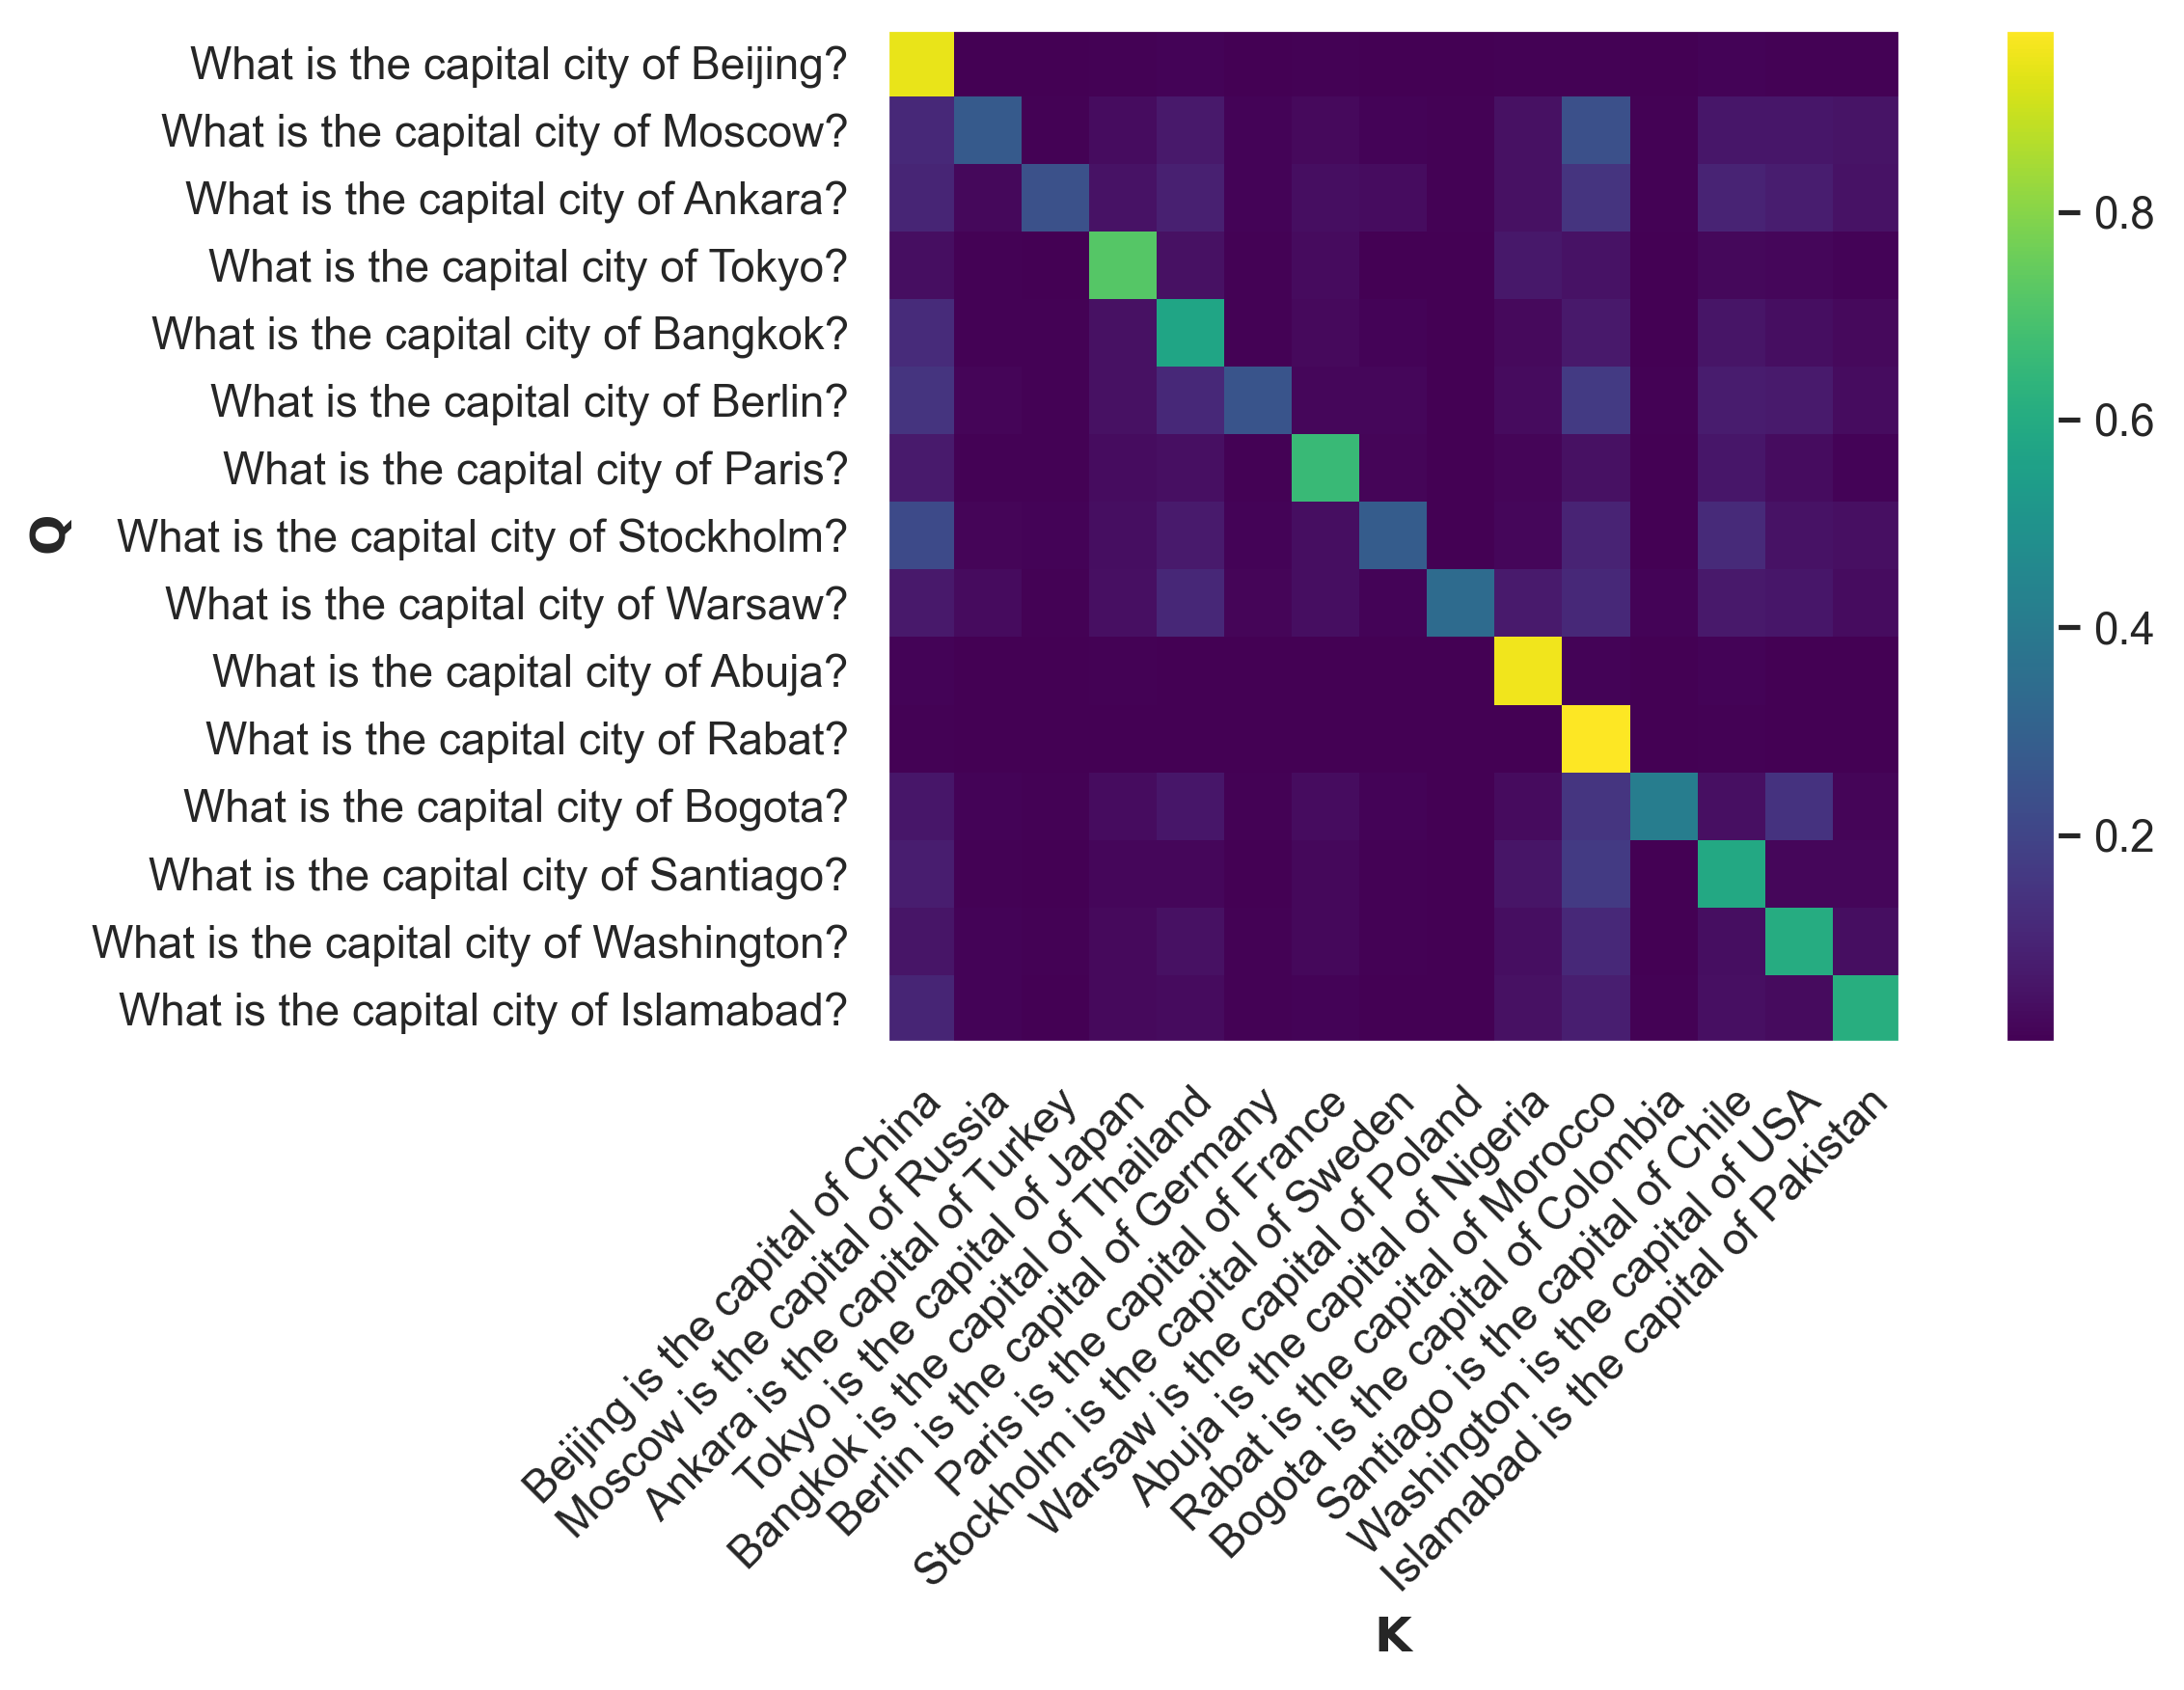

In [30]:
# Define some documents and questions
documents = [f"{city} is the capital of {country}" for city, country in zip(keys_cities_labels, keys_labels)]
questions =  [f"What is the capital city of {country}?" for country in keys_cities_labels]    # keys_labels

# Tokenizer
tokenizer_args = {"padding":True, "truncation":True, "return_tensors": "pt"}
documents_ = tokenizer(documents, **tokenizer_args)
questions_ = tokenizer(questions, **tokenizer_args)

# Compute the question and document vectors
with torch.no_grad():
    document_vectors = model(**documents_).pooler_output
    question_vectors = model(**questions_).pooler_output

# compute the inner product (attention map) between all pairs of questions and documents
attention_map = question_vectors @ document_vectors.T
attention_map = attention_map.softmax(dim=1)

# plot as an attention map
plot_attention_map(attention_map, questions, documents)

**Exercise 12**: Is DPR retrieving the right document for each question? Comment on the shape of the attention map.

> It's mostly correct, the shape is that of a diagonal line - that should be correct. However some of the answers have multiple similar candidates, which means that the model is not 100% certain about them.

---
## Credits and additional references

### Credits

Written by Valentin Liévin and reusing parts of the [Notebook](https://github.com/DeepLearningDTU/Deep-Learning-with-PyTorch-1weekcourse/tree/master/3_Recurrent/notebook_transformer) from Frederico Bergamin.


### Additional references

1. RNNs.
- [Blog post: "The Unreasonable Effectiveness of Recurrent Neural Networks" (Karpathy)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [lecture: "Language Models and RNNs" (Stanford)](https://www.youtube.com/watch?v=iWea12EAu6U&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z).

2. Transformers
- [Video from the main author of the paper](https://www.youtube.com/watch?v=rBCqOTEfxvg&t=894s)
- [Video lecture from Deepmind](https://www.youtube.com/watch?v=8zAP2qWAsKg&t=2073s)
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [Blog Post on the Positional Encoder](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
- [Transformer from Scratch](https://e2eml.school/transformers.html#positional_encoding)
- [Another blog post explaining transformer](https://jalammar.github.io/illustrated-transformer/)

### Re-using the images

[Figma design file](https://www.figma.com/file/d7BHs0yMhM9CTer43mrTe5/deep-learning-course?node-id=0%3A1)